# Creating Household Profiles based on Regulatory Settings

In this notebook, we create optimized household load profiles, based on given regulatory settings. The results are saved in the output folder, where they are later picked up for the grid analysis and the initial analysis of the aggregated profiles.

In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import os

In [2]:
print(gp.gurobi.version())

(9, 5, 0)


In [3]:
# In a first step, the input prices are loaded. We take day-ahead German spot market prices
# read EV data with multi-column index
df = pd.read_csv("./input/Hourly_EV_Charging.csv", sep=";", header=[0,1], index_col=0) # only for index, the actual EV data is handled separately
df.index = pd.to_datetime(df.index)

df_price = pd.read_excel("./input/Gro_handelspreise_201901010000_201912312359_Stunde.xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
2019-01-01 00:00:00+00:00,0.11833
2019-01-01 01:00:00+00:00,0.10008
2019-01-01 02:00:00+00:00,0.08593
2019-01-01 03:00:00+00:00,0.08010
2019-01-01 04:00:00+00:00,0.08260


In [4]:
# Now, we also load the 1kW nominal capacity PV generation in Hamelin
df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)

In [5]:
# Here, we load dataframes with 500 EV, HH and HP profiles. The household config decides which configuration per household is selected
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [6]:
# We use this function to later easily access the outputs of the Gurobi model

def get_results_in_df(m, variableNames, n_timesteps): #  
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   

    for n in variableNames:                                         
        for t in range(n_timesteps):                                
            VarName = n + f"[{t}]"                                  
            try:                                                    
                results_df.loc[t][n] = m.getVarByName(VarName).x    
            except:
                pass
    return results_df                                               

In [8]:
# we need this function for the rotating grid charge type
def adjust_grid_charges(length, grid_charges, starting_point):
    grid_charges_final = np.full(length, grid_charges/2)  
    offset = starting_point % 2  #starting based on idx inital idx_initial
    for i in range(offset, length, 2):  
        grid_charges_final[i] = grid_charges * 2
    return grid_charges_final

In [9]:
# Tariff settings
feed_in_tariff_fixed = 0.1187 # 0.07
grid_charge = 0.0722 # https://www.bundesnetzagentur.de/SharedDocs/Mediathek/Monitoringberichte/Monitoringbericht_VerbraucherKennzahlen2019.pdf
peak_power_charge = 67.94 #https://www.avacon-netz.de/content/dam/revu-global/avacon-netz/documents/netzentgelte-strom
segmented_charges = [grid_charge / 2, grid_charge, grid_charge * 2] # [EUR/kWh segment 1, EUR/kWh segment 2, ...]
segmented_limits = [2,    2,    None]   # [kWh segment 1, kWh segment 2, ...]; None for the last segment

In [15]:
# iterating over various variants
debug = False
household_n = 500 # must be less than 500

for pricing_type in ["dynamic"]: #["constant","dynamic"]
    for grid_charge_type in ["volumetric"]: #["volumetric","peak","segmented","rotating"]:
        for feed_in_type in ["fit"]: #["fit","dynamic"]
            for grid_charging_allowed in [False]:

                # "dynamic" or "constant"
                operation_type = "dynamic"  # "dynamic" or "constant"
                ev_charging_strategy = "early"  # "early" or "spread"; only relevant for operation_type = "constant"
                    # operation_type    |   ev_charging_strategy    |   explanation
                    # constant          |   early                   |   immediate charging when EV is plugged in
                    # constant          |   spread                  |   EV charging is spread over the entire plug-in time

                result_path = f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}_HPnew 0EV.pkl"
                print(f"Starting optimization for pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}")
                
                if debug is False:
                    if os.path.exists(result_path):
                        df_results = pd.read_pickle(result_path)
                    else:
                        df_results = pd.DataFrame()
                        df_results.index = df_p.index
                    
                else:
                    df_results = pd.DataFrame()
                    df_results.index = df_p.index

                for idx_initial, household in household_config.iloc[:household_n].iterrows():
                    print(idx_initial)
                    if str(idx_initial) not in df_results.columns: # check if already optimized that household
                        # Load data for the household
                        hp_load = df_hp[household["heat_pump_profile"]]
                        hh_load = df_hh[household["household_profile"]]
                        ev_load = df_ev[household["household_profile"]].copy().round(5)*(0.001)  # round to avoid numerical issues
                        pv_size = household["pv_power"]
                        bess_size = household["bess_capacity"]
                        max_bess_power = household["bess_power"]

                        # Transform ev load to kW and calculate maximum ev charging
                        ev_load["kWh"] = ev_load["Wh"].apply(lambda x:x/1000).values  # W to kW
                        max_ev_charging = (ev_load["kWh"] / ev_load["share_of_hour"]).max()
                        # Transform hh and hp load to kW and calculate maximum hp load
                        real_hh_load = hh_load.apply(lambda x:x/1000).values
                        real_hp_load = hp_load.apply(lambda x:x/1000).values
                        max_hp_load = real_hp_load.max()

                        # Other device settings
                        pv_size = bess_size
                        pv_load = df_pv["electricity"].apply(lambda x: x*pv_size).values
                        min_bess_energy = 0.05*bess_size
                        bess_efficiency = 0.95
                        guarantee_cycles = 365
                        max_blocking_events = 3

                        # Initialize environment and model
                        env = gp.Env(empty=True)
                        env.setParam("OutputFlag", 1)
                        env.start()
                        model = gp.Model("test", env=env)
                        model.setParam('MIPGap', 0.01) 
                        model.setParam('TimeLimit', 300)

                        length = len(df_p)
                        days = int(length/24)

                        # DETERMINING PRICES BASED ON TYPE
                        if pricing_type == "dynamic":
                            prices = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x).values
                        elif pricing_type == "constant":
                            average_price = df_p["Deutschland/Luxemburg [€/kWh]"].mean()
                            prices = np.full(length, average_price)
                        else:
                            raise ValueError("Pricing type not defined.")
                            
                        # DETERMINING GRID CHARGES TYPE
                        if grid_charge_type == "volumetric":
                            grid_charges  = np.full(length, grid_charge)
                        elif grid_charge_type =="peak":
                            grid_charges = np.full(length, 0)
                        elif grid_charge_type == "segmented":
                            grid_charges = np.full(length, 0)  # set the default grid charge to zero; the cost for each segment will be added later on
                        elif grid_charge_type == "rotating":
                            found_starting_point = False
                            starting_point=0
                            while found_starting_point is False:
                                modulo_value = (idx_initial+starting_point)%2
                                if modulo_value != 0:
                                    starting_point = starting_point+1
                                else:
                                    found_starting_point = True
                            print(idx_initial)
                            print(f"Starting point is: {starting_point}")
                            grid_charges_final = adjust_grid_charges(length, grid_charge, starting_point)
                            grid_charges = grid_charges_final
                        else:
                            raise ValueError("Grid charge type not properly defined.")

                        # DETERMINING FEED-IN REMUNERATION
                        if feed_in_type == "fit":
                            feed_in_tariff = np.full(length, feed_in_tariff_fixed)
                        elif feed_in_type == "dynamic":
                            feed_in_tariff = df_p["Deutschland/Luxemburg [€/kWh]"].values
                        elif feed_in_type == "zero":
                            feed_in_tariff = np.full(length, 0)
                        else:
                            raise ValueError("Feed-in remuneration not defined.")

                        # Initialize variables
                        #if operation_type == "dynamic":
                        opt_ev_charging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_ch_opt")
                        opt_hp_load = model.addVars([t for t in range(length)], lb=0, vtype=GRB.CONTINUOUS, name="p_hp_opt")
                        opt_bess_charging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_bess_ch_opt")
                        opt_bess_discharging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_bess_dch_opt")
                        opt_net_energy = model.addVars([t for t in range(length)], lb=0, vtype=GRB.CONTINUOUS, name="opt_net_energy")
                        buy_energy = model.addVars(length, vtype=GRB.BINARY, name="buy_energy") # positive when grid intake, zero when feed-out
                        e_bess = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="e_bess")

                        energy_costs = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name="energy_costs")
                        feedin_profits = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name="feedin_profits")

                        opt_feed_out_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_feed_out_pv")
                        opt_internaluse_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_internaluse_pv")

                        block_hp = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name="blocked_heatpump_event")
                        block_hp_hour = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name="blocked_heatpump_hour")

                        # regulatory options
                        max_net_energy = model.addVar(name="max_net_energy")
                        if grid_charge_type == "segmented":
                            energy_per_segment = model.addVars([t for t in range(length)], [s for s in range(len(segmented_charges))], lb=0, vtype=GRB.CONTINUOUS, name="energy_per_segment")  # upper bounds are set in the constraints

                        #### ELECTRIC VEHICLE
                        # ensure that charging requirements are met
                        if operation_type == "dynamic":
                            for ts_start in ev_load[ev_load["start"] > 0].index:
                                hours_until_end = int(ev_load.loc[ts_start, "hours_until_end"])
                                # ts_start is the timestamp when the charging session starts; convert to integer index
                                idx_start = ev_load.index.get_loc(ts_start)
                                idx_end = idx_start + hours_until_end
                                # ensure that the energy demand of each charging session is met
                                model.addConstr(quicksum(opt_ev_charging[t] for t in range(idx_start, idx_end + 1)) ==
                                                quicksum(ev_load.iloc[t]["kWh"] for t in range(idx_start, idx_end + 1)), f"energy_charging_session_{idx_start}")
                                                # idx_end must be included --> + 1

                            # ensure maximum empirical EV charging is never exceeded
                            # if the EV is only plugged in for a fraction of the hour (i.e., share_of_hour < 1),
                            # it can also only charge for that fraction
                            model.addConstrs(opt_ev_charging[t] <= max_ev_charging * ev_load.iloc[t]["share_of_hour"] for t in range(length))
                        elif operation_type == "constant" and ev_charging_strategy == "early":
                            # run helper optimization to define charging power in each time step
                            model_h = gp.Model("ev_early_charging", env=env)
                            opt_ev_charging_h = model_h.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_ch_opt_h")
                            coeff_early_charging = [0] * len(ev_load)  # used in the objective function
                            for ts_start in ev_load[ev_load["start"] > 0].index:
                                hours_until_end = int(ev_load.loc[ts_start, "hours_until_end"])
                                # ts_start is the timestamp when the charging session starts ; convert to integer index
                                idx_start = ev_load.index.get_loc(ts_start)
                                idx_end = idx_start + hours_until_end
                                # ensure that the energy demand of each charging session is met
                                model_h.addConstr(quicksum(opt_ev_charging_h[t] for t in range(idx_start, idx_end + 1)) ==
                                                quicksum(ev_load.iloc[t]["kWh"] for t in range(idx_start, idx_end + 1)))
                                coeff_early_charging[idx_start:idx_end + 1] = range(hours_until_end + 1)

                            # ensure maximum empirical EV charging is never exceeded
                            model_h.addConstrs(opt_ev_charging_h[t] <= max_ev_charging * ev_load.iloc[t]["share_of_hour"] for t in range(length))

                            # objective function
                            model_h.setObjective(quicksum(opt_ev_charging_h[t] * coeff_early_charging[t] for t in range(length)), GRB.MINIMIZE)
                            model_h.optimize()

                            # assign results to the main model
                            model.addConstrs(opt_ev_charging[t] == opt_ev_charging_h[t].x for t in range(length))
                        else:
                            # EV load is spread over the entire plug-in time; this is how input data is formatted
                            model.addConstrs(opt_ev_charging[t] == ev_load.iloc[t]["kWh"] for t in range(length))

                        #### HEAT PUMP
                        if operation_type == "dynamic":
                            # limit the number of blocking events per 24h-window
                            model.addConstrs((quicksum(block_hp[t] for t in range(k, k+24)) <= max_blocking_events for k in range(length-23)), name="max_blocking_events_per_24h")  # alternative to per day
                            # counter of blocking events; block_hp = 1 if there is a switch from blocked to unblocked
                            model.addConstrs((block_hp[t] >= block_hp_hour[t-1] - block_hp_hour[t] for t in range(1, length)), name="end_blocking_event")
                            # after a blocking event, the HP must be unblocked for at least 2 hours
                            model.addConstrs((block_hp_hour[t] + block_hp_hour[t+1] <= 2 * (1-block_hp[t]) for t in range(length-1)), name="min_unblock")
                            # the HP can at most be blocked for 2 consecutive hours
                            model.addConstrs((block_hp_hour[t] + block_hp_hour[t+1] + block_hp_hour[t+2] <= 2 for t in range(length-2)), name="max_block")

                            # limits in each time step
                            for t in range(length):
                                model.addConstr(opt_hp_load[t] <= max_hp_load)
                                model.addConstr(opt_hp_load[t] >= (1 - block_hp_hour[t]) * real_hp_load[t])
                                model.addConstr(opt_hp_load[t] <= (1 - block_hp_hour[t]) * max_hp_load) # making sure that albeit the flexible constraint blocking hours lead to complete blocking

                            # ensure that the sum of heat pump load every 6 hours remains in the same range
                            for idx in range(days * 4):
                                idx_start = idx * 6
                                idx_end = (idx + 1) * 6
                                if idx_end > length:
                                    idx_end = length  # Ensure we don't exceed the bounds
                                model.addConstr(quicksum(opt_hp_load[t] for t in range(idx_start, idx_end)) == quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))

                        elif operation_type == "constant":
                            model.addConstrs(opt_hp_load[t] == real_hp_load[t] for t in range(length))

                        #### BATTERY STORAGE
                        model.addConstr(e_bess[0]==min_bess_energy)

                        for t in range(length):
                            model.addConstr(opt_bess_charging[t] * opt_bess_discharging[t] == 0, "mutual_exclusivity_" + str(t))
                            model.addConstr(opt_net_energy[t] * opt_feed_out_pv[t] == 0, "mutual_exclusivity_pv_" + str(t)) # mutual exclusivity for pv feed out and net energy 
                            model.addConstr(opt_bess_charging[t]<=max_bess_power)
                            model.addConstr(opt_bess_discharging[t]<=max_bess_power)
                            if grid_charging_allowed is not True:
                                model.addConstr(opt_bess_charging[t]<=opt_internaluse_pv[t])


                        for t in range(1, length):
                            model.addConstr(e_bess[t]==e_bess[t-1]+opt_bess_charging[t-1]*bess_efficiency-opt_bess_discharging[t-1]/bess_efficiency)
                            model.addConstr(e_bess[t]>=min_bess_energy)
                            model.addConstr(e_bess[t]<=bess_size)

                        model.addConstr(quicksum(opt_bess_discharging[t] + opt_bess_charging[t] for t in range(length)) <= bess_size*2*guarantee_cycles, "guarantee_cycles")


                        ### OPTI
                        # calculate net energy of household
                        if operation_type == "dynamic":
                            model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]*bess_efficiency-opt_bess_discharging[t]/bess_efficiency+opt_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
                        elif operation_type == "constant" and ev_charging_strategy == "early":
                            model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
                        else:
                            model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+ev_load.iloc[t]["kWh"]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t]) for t in range(length))


                        # regulatory cases
                        if grid_charge_type == "peak":
                            for t in range(length):
                                model.addConstr(max_net_energy >= opt_net_energy[t], name=f"max_constraint_{t}")
                        elif grid_charge_type == "segmented":
                            model.addConstrs((quicksum(energy_per_segment[t,s] for s in range(len(segmented_charges))) == opt_net_energy[t] for t in range(length)), name="sum_energy_per_segment")
                            model.addConstrs((energy_per_segment[t,s] <= segmented_limits[s] for t in range(length) for s in range(len(segmented_charges) - 1)), name="upper_bound_segment")  # no upper bound for the last segment
                        # model.addConstr(opt_net_energy[t] >= 0)  # commented out by Kathi; Lower bound in variable definition is 0

                        # energy costs
                        for t in range(length):
                            model.addConstr((opt_internaluse_pv[t]+opt_feed_out_pv[t])==pv_load[t]) # TODO: adding efficiency
                            model.addConstr(energy_costs[t] == ((opt_net_energy[t]) * (prices[t]+grid_charges[t]) ), "calc_energy_costs_" + str(t))
                            model.addConstr(feedin_profits[t] == opt_feed_out_pv[t]*feed_in_tariff[t], "calc_energy_profits_" + str(t))

                        # objective function
                        if grid_charge_type == "peak":
                            model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length))+max_net_energy*peak_power_charge, GRB.MINIMIZE)
                        elif grid_charge_type == "segmented":
                            model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length))+quicksum(energy_per_segment[t,s]*segmented_charges[s] for t in range(length) for s in range(len(segmented_charges))), GRB.MINIMIZE)
                        else:
                            model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length)), GRB.MINIMIZE) 

                        # optimize
                        model.optimize()

                        # get results
                        vn = ["opt_net_energy","energy_costs","p_ch_opt","p_hp_opt","blocked_heatpump_event","blocked_heatpump_hour","p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","opt_internaluse_pv","e_bess","feedin_profits"] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimierung)
                        n = length
                        temp_results = get_results_in_df(model, vn, n)
                        df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
                        #df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
                        #df_results_ev[str(idx_initial)] = temp_results["p_ch_opt"].values

                        if df_results.isna().any().any():
                            raise ValueError(f"Results for {grid_charge_type} {feed_in_type} {str(grid_charging_allowed)} contain NaN values, indicating infeasibility of some models.")
                        else:
                            if debug is False:
                                df_results.to_pickle(result_path)
                            #df_results_hp.to_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                            #df_results_ev.to_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                            #df_results_feedinprofits.to_pickle(f"./output/detailed_financials/FI_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                            #df_results_costs.to_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                    else:
                        print(str(idx_initial)+" has been already optimized for that case.")


Starting optimization for pricing_dynamic_operation_dynamic_fi_fit_ne_volumetric_gridch_False
158
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x99d12810
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 72176 rows and 51075 columns
Presolve time: 1.29s
Presolved: 87126 rows, 62806 columns, 456661 nonzeros
Variable types: 37292 continuous, 25514 integer (25514 binary)
Found heuristic sol

     0     0 1420.76904    0 3635 1488.64319 1420.76904  4.56%     -    5s
H    0     0                    1431.8936820 1420.76904  0.78%     -    5s

Cutting planes:
  Learned: 7
  Gomory: 56
  Cover: 150
  Implied bound: 9
  MIR: 944
  Flow cover: 554
  Zero half: 65
  RLT: 1806
  Relax-and-lift: 281

Explored 1 nodes (62587 simplex iterations) in 5.44 seconds (9.26 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 1431.89 1488.64 1488.96 1488.97 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.431893682022e+03, best bound 1.420769040335e+03, gap 0.7769%
356
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1394.25372    0 5140 1470.78259 1394.25372  5.20%     -    4s
H    0     0                    1470.4979697 1394.25372  5.18%     -    4s
     0     0 1401.36598    0 3562 1470.49797 1401.36598  4.70%     -    5s
H    0     0                    1413.4729303 1401.36598  0.86%     -    5s

Cutting planes:
  Learned: 2
  Gomory: 61
  Cover: 133
  Implied bound: 10
  MIR: 1015
  Flow cover: 530
  Zero half: 51
  RLT: 2084
  Relax-and-lift: 274

Explored 1 nodes (66221 simplex iterations) in 6.00 seconds (9.71 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 1413.47 1470.5 1470.78 ... 1472.55

Optimal solution found (tolerance 1.00e-02)
Best objective 1.413472930293e+03, best bound 1.401365976611e+03, gap 0.8565%
166
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 


Root relaxation: objective 1.382585e+03, 43510 iterations, 1.24 seconds (1.72 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1382.58484    0 5018 1457.23616 1382.58484  5.12%     -    3s
H    0     0                    1457.2217925 1382.58484  5.12%     -    3s
     0     0 1389.54608    0 3735 1457.22179 1389.54608  4.64%     -    5s
H    0     0                    1399.6477412 1389.54608  0.72%     -    5s

Cutting planes:
  Learned: 7
  Gomory: 51
  Cover: 150
  Implied bound: 10
  MIR: 976
  Flow cover: 543
  Zero half: 67
  RLT: 1960
  Relax-and-lift: 308

Explored 1 nodes (65532 simplex iterations) in 5.52 seconds (9.49 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1399.65 1457.22 1457.24 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.399647741159e+03, best bound 1.389546082738e+03, gap 0.7217%
354
Set p

Found heuristic solution: objective 1404.8813179

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.326918e+03, 44102 iterations, 1.24 seconds (1.77 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1326.91784    0 5331 1404.88132 1326.91784  5.55%     -    3s
H    0     0                    1404.5516228 1326.91784  5.53%     -    3s
     0     0 1333.17883    0 3746 1404.55162 1333.17883  5.08%     -    5s
H    0     0                    1343.9269523 1333.17883  0.80%     -    5s

Cutting planes:
  Learned: 4
  Gomory: 62
  Cover: 153
  Implied bound: 12
  Clique: 1
  MIR: 906
  StrongCG: 1
  Flow cover: 554
  Zero half: 61
  RLT: 2152
  Relax-and-lift: 290

Explored 1 nodes (65762 simplex iterations) in 5.55 seconds (9.62 work units)
Thr

Presolve time: 0.96s
Presolved: 85623 rows, 59485 columns, 448242 nonzeros
Variable types: 34477 continuous, 25008 integer (25008 binary)
Found heuristic solution: objective 683.9281690

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.264805e+02, 38813 iterations, 1.11 seconds (1.50 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  626.48045    0 4482  683.92817  626.48045  8.40%     -    3s
H    0     0                     683.6364380  626.48045  8.36%     -    3s
     0     0  629.33797    0 4088  683.63644  629.33797  7.94%     -    4s
H    0     0                     637.0557090  629.33797  1.21%     -    5s
     0     0  629.40269    0 4153  637.05571  629.40269  1.20%     -    6s
     0     0  629.40577    0 4146  637.05571  629.4


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  601.80297    0 4525  662.97233  601.80297  9.23%     -    4s
H    0     0                     662.5244738  601.80297  9.17%     -    4s
     0     0  604.28615    0 3960  662.52447  604.28615  8.79%     -    5s
H    0     0                     614.4389210  604.28615  1.65%     -    5s
     0     0  604.37591    0 3974  614.43892  604.37591  1.64%     -    6s
     0     0  604.38900    0 3938  614.43892  604.38900  1.64%     -    8s
     0     0  604.38902    0 3937  614.43892  604.38902  1.64%     -    8s
     0     0  604.93556    0 2090  614.43892  604.93556  1.55%     -    9s
H    0     0                     610.4377236  604.93556  0.90%     -    9s

Cutting planes:
  Learned: 5
  Gomory: 121
  Cover: 256
  Implied bound: 157
  Clique: 10
  MIR: 1555
  Flow cover: 1169
  Zero half: 101
  RLT: 2164
  Relax-and-lift: 294


     0     0  583.75947    0 1445  590.51695  583.75947  1.14%     -   10s
     0     0  583.76011    0 1471  590.51695  583.76011  1.14%     -   10s
     0     0  583.81362    0 1308  590.51695  583.81362  1.14%     -   10s
H    0     0                     584.9255600  583.81362  0.19%     -   11s

Cutting planes:
  Learned: 8
  Gomory: 123
  Cover: 261
  Implied bound: 160
  Clique: 7
  MIR: 1849
  Flow cover: 1207
  Zero half: 123
  RLT: 2288
  Relax-and-lift: 296

Explored 1 nodes (63275 simplex iterations) in 11.11 seconds (21.28 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 584.926 590.517 637.622 638.217 

Optimal solution found (tolerance 1.00e-02)
Best objective 5.849255599958e+02, best bound 5.838136162162e+02, gap 0.1901%
255
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rose

     0     0  574.41443    0 3536  632.23712  574.41443  9.15%     -    7s
     0     0  574.41671    0 3544  632.23712  574.41671  9.15%     -    8s
     0     0  574.41674    0 3548  632.23712  574.41674  9.15%     -    8s
     0     0  574.99568    0 2033  632.23712  574.99568  9.05%     -    9s
H    0     0                     579.0326019  574.99568  0.70%     -    9s

Cutting planes:
  Learned: 2
  Gomory: 119
  Cover: 270
  Implied bound: 149
  Clique: 7
  MIR: 1497
  StrongCG: 1
  Flow cover: 1125
  Zero half: 83
  RLT: 1833
  Relax-and-lift: 297

Explored 1 nodes (60743 simplex iterations) in 9.26 seconds (17.55 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 579.033 632.237 632.468 ... 633.817

Optimal solution found (tolerance 1.00e-02)
Best objective 5.790326018723e+02, best bound 5.749956846239e+02, gap 0.6972%
329
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set p

  Implied bound: 125
  Clique: 9
  MIR: 1473
  Flow cover: 1167
  Zero half: 83
  RLT: 1775
  Relax-and-lift: 319

Explored 1 nodes (64588 simplex iterations) in 8.43 seconds (18.08 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 572.185 578.881 623.908 ... 624.181

Optimal solution found (tolerance 1.00e-02)
Best objective 5.721851716018e+02, best bound 5.693011444651e+02, gap 0.5040%
364
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xd0241c45
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix rang

H    0     0                     616.8742726  557.88080  9.56%     -   14s
     0     0  557.88193    0  975  616.87427  557.88193  9.56%     -   14s
     0     0  557.88193    0  975  616.87427  557.88193  9.56%     -   14s
     0     0  557.89093    0  952  616.87427  557.89093  9.56%     -   15s
     0     0  557.89093    0  951  616.87427  557.89093  9.56%     -   15s
     0     0  557.89357    0  954  616.87427  557.89357  9.56%     -   16s
H    0     0                     616.2214258  557.89357  9.47%     -   16s
     0     0  557.89365    0  954  616.22143  557.89365  9.47%     -   16s
     0     0  557.89482    0  908  616.22143  557.89482  9.47%     -   16s
     0     0  557.89488    0  913  616.22143  557.89488  9.47%     -   17s
     0     0  557.89567    0  915  616.22143  557.89567  9.47%     -   17s
     0     0  557.89567    0  853  616.22143  557.89567  9.47%     -   18s
H    0     0                     558.2119132  557.89567  0.06%     -   18s

Cutting planes:
  Learne

     0     0  423.20468    0 3514  427.80944  423.20468  1.08%     -    6s
     0     0  423.20828    0 3451  427.80944  423.20828  1.08%     -    7s
     0     0  423.20828    0 3454  427.80944  423.20828  1.08%     -    7s
     0     0  423.53519    0 2073  427.80944  423.53519  1.00%     -    8s

Cutting planes:
  Learned: 3
  Gomory: 133
  Cover: 224
  Implied bound: 125
  Clique: 9
  MIR: 1985
  StrongCG: 3
  Flow cover: 994
  GUB cover: 1
  Zero half: 168
  RLT: 1532
  Relax-and-lift: 248

Explored 1 nodes (71779 simplex iterations) in 8.35 seconds (16.76 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 427.809 433.669 433.75 471.913 

Optimal solution found (tolerance 1.00e-02)
Best objective 4.278094356626e+02, best bound 4.235351916176e+02, gap 0.9991%
496
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 b

Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+03]
Presolve removed 72010 rows and 51550 columns
Presolve time: 0.99s
Presolved: 87285 rows, 62331 columns, 454122 nonzeros
Variable types: 36789 continuous, 25542 integer (25542 binary)
Found heuristic solution: objective 456.9482379
Found heuristic solution: objective 456.9223126

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 4.078877e+02, 49923 iterations, 1.26 seconds (1.78 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  407.88772    0 4250  45

     0     0  530.45307    0 4592  539.31157  530.45307  1.64%     -    6s
     0     0  530.45579    0 4590  539.31157  530.45579  1.64%     -    7s
     0     0  530.45579    0 4595  539.31157  530.45579  1.64%     -    7s
     0     0  531.08249    0 2258  539.31157  531.08249  1.53%     -    8s
H    0     0                     534.0415163  531.08249  0.55%     -    8s

Cutting planes:
  Learned: 6
  Gomory: 121
  Cover: 233
  Implied bound: 153
  Clique: 7
  MIR: 1459
  StrongCG: 1
  Flow cover: 1127
  Zero half: 75
  RLT: 1845
  Relax-and-lift: 312

Explored 1 nodes (64149 simplex iterations) in 8.75 seconds (20.11 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 534.042 539.312 587.956 588.076 

Optimal solution found (tolerance 1.00e-02)
Best objective 5.340415163256e+02, best bound 5.310824869154e+02, gap 0.5541%
414
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set para

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 73728 rows and 54192 columns
Presolve time: 1.06s
Presolved: 85504 rows, 59689 columns, 448368 nonzeros
Variable types: 34715 continuous, 24974 integer (24974 binary)
Found heuristic solution: objective 591.6096279

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.259368e+02, 38205 iterations, 1.04 seconds (1.43 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  525.93677    0 4279  591.60963  525.93677  11.1%     -    3s
H    0     0                     590.9089320  525.93677  11.0%     -    3s
     0     0  528.44383    0 4025  590.90893  528.44383  10.6%     -    4s
H    0     0                     536.3377999  528.443


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  381.63941    0 4790  436.59681  381.63941  12.6%     -    4s
H    0     0                     395.1906517  381.63941  3.43%     -    4s
H    0     0                     395.1758479  381.63941  3.43%     -    4s
     0     0  384.05956    0 3522  395.17585  384.05956  2.81%     -    5s
H    0     0                     388.3426190  384.05956  1.10%     -    5s
H    0     0                     387.4847314  384.05956  0.88%     -    5s

Cutting planes:
  Learned: 10
  Gomory: 72
  Cover: 125
  Implied bound: 18
  MIR: 966
  Flow cover: 483
  Zero half: 76
  RLT: 1630
  Relax-and-lift: 177

Explored 1 nodes (68484 simplex iterations) in 5.89 seconds (10.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 387.485 388.343 395.176 ... 436.597

Optimal solution found (tolerance 1.00e-02)
Best objective 

Thread count was 8 (of 8 available processors)

Solution count 4: 392.063 395.959 441.428 442.02 

Optimal solution found (tolerance 1.00e-02)
Best objective 3.920634096654e+02, best bound 3.904373531422e+02, gap 0.4147%
100
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x09612f7c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 72733 rows and 51612 columns
Presolve time: 0.94s
Presolved

  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+03]
Presolve removed 72752 rows and 53225 columns
Presolve time: 0.94s
Presolved: 86501 rows, 60656 columns, 452842 nonzeros
Variable types: 35349 continuous, 25307 integer (25307 binary)
Found heuristic solution: objective 517.9989758
Found heuristic solution: objective 517.9797740

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.612433e+02, 40640 iterations, 1.00 seconds (1.41 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  461.24326    0 4462  517.97977  461.24326  11.0%     -    3s
H    0     0                     517.8850709  461.24326  10.9%     -    3s
     0     0


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  454.40634    0 4635  514.14292  454.40634  11.6%     -    3s
H    0     0                     514.1245588  454.40634  11.6%     -    3s
     0     0  456.69603    0 3119  514.12456  456.69603  11.2%     -    4s
H    0     0                     463.3071338  456.69603  1.43%     -    5s
     0     0  456.80422    0 3061  463.30713  456.80422  1.40%     -    6s
     0     0  456.80504    0 3032  463.30713  456.80504  1.40%     -    6s
     0     0  457.22529    0 2057  463.30713  457.22529  1.31%     -    7s
H    0     0                     459.7172802  457.22529  0.54%     -    7s

Cutting planes:
  Learned: 10
  Gomory: 107
  Cover: 184
  Implied bound: 77
  Clique: 6
  MIR: 1306
  Flow cover: 777
  Zero half: 81
  RLT: 1775
  Relax-and-lift: 176

Explored 1 nodes (64302 simplex iterations) in 7.94 seconds (16.28 work units


Solution count 4: 381.278 384.223 424.851 425.172 

Optimal solution found (tolerance 1.00e-02)
Best objective 3.812782669106e+02, best bound 3.793133054125e+02, gap 0.5154%
304
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x113f8216
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 7e+03]
Presolve removed 71910 rows and 53493 columns
Presolve time: 0.94s
Presolved: 87234 rows, 60388 columns, 452273 nonzeros
V

  Matrix range     [1e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+03]
Presolve removed 72139 rows and 52491 columns
Presolve time: 0.95s
Presolved: 87113 rows, 61390 columns, 452447 nonzeros
Variable types: 35904 continuous, 25486 integer (25486 binary)
Found heuristic solution: objective 404.3123534

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.559144e+02, 49503 iterations, 1.22 seconds (1.77 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  355.91438    0 4105  404.31235  355.91438  12.0%     -    3s
H    0     0                     404.0515721  355.91438  11.9%     -    4s
     0     0  357.54224    0 3235  404.05157  357.54224  11.

Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.250637e+02, 41065 iterations, 1.09 seconds (1.50 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  425.06373    0 4620  479.51730  425.06373  11.4%     -    3s
H    0     0                     478.8318031  425.06373  11.2%     -    3s
     0     0  427.28822    0 3429  478.83180  427.28822  10.8%     -    4s
     0     0  427.35150    0 3225  478.83180  427.35150  10.8%     -    6s
     0     0  427.35268    0 3207  478.83180  427.35268  10.8%     -    6s
     0     0  427.35268    0 3207  478.83180  427.35268  10.8%     -    6s
     0     0  427.73917    0 1952  478.83180  427.73917  10.7%     -    7s
H    0     0                     430.0174129  427.73917  0.53%     -    7s

Cutting planes:
  Learned: 14
  Gomory: 120
  Cover: 193
  Implied bound: 8

     0     0  412.77418    0 3176  419.01597  412.77418  1.49%     -    6s
     0     0  412.77420    0 3183  419.01597  412.77420  1.49%     -    6s
     0     0  413.26628    0 2054  419.01597  413.26628  1.37%     -    7s
H    0     0                     415.6883824  413.26628  0.58%     -    7s

Cutting planes:
  Learned: 11
  Gomory: 130
  Cover: 198
  Implied bound: 111
  Clique: 7
  MIR: 1280
  Flow cover: 733
  Zero half: 82
  RLT: 1839
  Relax-and-lift: 176

Explored 1 nodes (63085 simplex iterations) in 7.92 seconds (16.99 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 415.688 419.016 462.736 ... 462.983

Optimal solution found (tolerance 1.00e-02)
Best objective 4.156883823858e+02, best bound 4.132662767287e+02, gap 0.5827%
272
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[ros

     0     0  391.45147    0 1568  396.82245  391.45147  1.35%     -    7s
H    0     0                     393.1233668  391.45147  0.43%     -    7s

Cutting planes:
  Learned: 11
  Gomory: 119
  Cover: 198
  Implied bound: 89
  Clique: 7
  MIR: 1337
  StrongCG: 1
  Flow cover: 807
  Zero half: 99
  RLT: 1663
  Relax-and-lift: 201

Explored 1 nodes (62171 simplex iterations) in 7.89 seconds (16.05 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 393.123 396.822 407.734 ... 446.761

Optimal solution found (tolerance 1.00e-02)
Best objective 3.931233668370e+02, best bound 3.914514672632e+02, gap 0.4253%
37
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x0b174d68
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 72787 rows and 51954 columns
Presolve time: 0.99s
Presolved: 86483 rows, 61927 columns, 454250 nonzeros
Variable types: 36624 continuous, 25303 integer (25303 binary)
Found heuristic solution: objective 415.6999145

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.614594e+02, 42793 iterations, 1.10 seconds (1.54 work uni


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.535853e+02, 40872 iterations, 1.07 seconds (1.50 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  353.58529    0 3996  407.38155  353.58529  13.2%     -    3s
H    0     0                     407.1783005  353.58529  13.2%     -    3s
     0     0  356.09286    0 3146  407.17830  356.09286  12.5%     -    5s
H    0     0                     361.8008362  356.09286  1.58%     -    5s
H    0     0                     361.6432686  356.09286  1.53%     -    5s
     0     0  356.14432    0 3139  361.64327  356.14432  1.52%     -    6s
     0     0  356.14481    0 3135  361.64327  356.14481  1.52%     -    6s
     0     0  356.14481    0 3135  361.64327  356.14481  1.52%     -    7s
     0     0

H    0     0                     331.4125717  324.61470  2.05%     -    5s
     0     0  324.67323    0 2945  331.41257  324.67323  2.03%     -    6s
     0     0  324.67413    0 2936  331.41257  324.67413  2.03%     -    6s
     0     0  324.67414    0 2940  331.41257  324.67414  2.03%     -    6s
     0     0  325.03027    0 1884  331.41257  325.03027  1.93%     -    7s
H    0     0                     327.4303069  325.03027  0.73%     -    7s

Cutting planes:
  Learned: 15
  Gomory: 113
  Cover: 159
  Implied bound: 105
  Clique: 4
  MIR: 1235
  StrongCG: 1
  Flow cover: 743
  Zero half: 78
  RLT: 1904
  Relax-and-lift: 144

Explored 1 nodes (63198 simplex iterations) in 7.86 seconds (16.30 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 327.43 331.413 375.331 ... 375.412

Optimal solution found (tolerance 1.00e-02)
Best objective 3.274303068618e+02, best bound 3.250302657175e+02, gap 0.7330%
165
Set parameter Username
Academic license - for non-commerc


Optimal solution found (tolerance 1.00e-02)
Best objective 2.764541982998e+02, best bound 2.744454382199e+02, gap 0.7266%
482
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xe54007e5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+03]
Presolve removed 72977 rows and 53539 columns
Presolve time: 0.96s
Presolved: 86244 rows, 60342 columns, 452424 nonzeros
Variable types: 35164 continuous, 25178 integer (2517

Best objective 2.150981088674e+02, best bound 2.136362435084e+02, gap 0.6796%
119
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x9fbda373
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 8e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+03]
Presolve removed 72904 rows and 54159 columns
Presolve time: 1.02s
Presolved: 86281 rows, 59722 columns, 452966 nonzeros
Variable types: 34493 continuous, 25229 integer (25229 binary)
Found heuristic solution: objective

Presolve time: 0.93s
Presolved: 86329 rows, 61986 columns, 455412 nonzeros
Variable types: 36738 continuous, 25248 integer (25248 binary)
Found heuristic solution: objective 244.9365206
Found heuristic solution: objective 244.8332421

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.976929e+02, 43822 iterations, 1.22 seconds (1.74 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  197.69291    0 4314  244.83324  197.69291  19.3%     -    3s
H    0     0                     244.6038011  197.69291  19.2%     -    4s
     0     0  200.90244    0 2838  244.60380  200.90244  17.9%     -    5s
H    0     0                     208.6295388  200.90244  3.70%     -    5s
     0     0  200.95461    0 2896  208.62954  200.95461  3.68%     -    6s
   

     0     0  174.24250    0 1491  176.09755  174.24250  1.05%     -    7s
     0     0  174.31337    0 1179  176.09755  174.31337  1.01%     -    8s
H    0     0                     175.6669550  174.31337  0.77%     -    8s

Cutting planes:
  Learned: 13
  Gomory: 102
  Cover: 204
  Implied bound: 100
  Clique: 3
  MIR: 1464
  Flow cover: 900
  Zero half: 83
  RLT: 2158
  Relax-and-lift: 222

Explored 1 nodes (64651 simplex iterations) in 8.96 seconds (17.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 175.667 176.098 179.705 ... 219.037

Optimal solution found (tolerance 1.00e-02)
Best objective 1.756669550020e+02, best bound 1.743133654201e+02, gap 0.7705%
237
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0xe00378d1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+03]
Presolve removed 72804 rows and 53540 columns
Presolve time: 0.95s
Presolved: 86416 rows, 60341 columns, 453316 nonzeros
Variable types: 35090 continuous, 25251 integer (25251 binary)
Found heuristic solution: objective 170.2670923
Found heuristic solution: objective 170.2107596

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 1.171272e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xd311a3c0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+03]
Presolve removed 72824 rows and 52378 columns
Presolve time: 1.02s
Presolved: 86352 rows, 61503 columns, 454514 nonzeros
Variable types: 36283 continuous, 25220 integer (25220 binary)
Found heuristic solution: objective 164.0996655
Found heuristic solution: objective 163.9722535

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x572998a2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+03]
Presolve removed 72959 rows and 52662 columns
Presolve time: 0.98s
Presolved: 86336 rows, 61219 columns, 454402 nonzeros
Variable types: 35971 continuous, 25248 integer (25248 binary)
Found heuristic solution: objective 221.9502359
Found heuristic solution: objective 221.9469620
Found heuristic solution: objective 221.9416103

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0x5ffd4e4a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+03]
Presolve removed 72835 rows and 54106 columns
Presolve time: 0.95s
Presolved: 86349 rows, 59775 columns, 453287 nonzeros
Variable types: 34520 continuous, 25255 integer (25255 binary)
Found heuristic solution: objective 218.3219803

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 1.723404e+02, 41621 iterations, 1.18 seconds (1.71 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x4b281d89
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 7e+03]
Presolve removed 72934 rows and 52637 columns
Presolve time: 0.97s
Presolved: 86361 rows, 61244 columns, 454534 nonzeros
Variable types: 35988 continuous, 25256 integer (25256 binary)
Found heuristic solution: objective 204.7394054
Found heuristic solution: objective 204.7345865

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.615238e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x5d11aa74
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 73113 rows and 53535 columns
Presolve time: 0.95s
Presolved: 86266 rows, 60346 columns, 453500 nonzeros
Variable types: 35120 continuous, 25226 integer (25226 binary)
Found heuristic solution: objective 206.8289996
Found heuristic solution: objective 206.1830815

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.569854e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0xc59fff61
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 7e+03]
Presolve removed 72849 rows and 54593 columns
Presolve time: 0.94s
Presolved: 86295 rows, 59288 columns, 452778 nonzeros
Variable types: 34051 continuous, 25237 integer (25237 binary)
Found heuristic solution: objective 212.3103842

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.691595e+02, 40643 iterations, 1.12 seconds (1.64 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0x597c7485
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+03]
Presolve removed 72851 rows and 52675 columns
Presolve time: 0.94s
Presolved: 86324 rows, 61206 columns, 454293 nonzeros
Variable types: 35964 continuous, 25242 integer (25242 binary)
Found heuristic solution: objective 194.6812600

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.515214e+02, 42503 iterations, 1.17 seconds (1.72 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0xcabbe0b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 73009 rows and 51991 columns
Presolve time: 0.93s
Presolved: 86242 rows, 61890 columns, 454828 nonzeros
Variable types: 36670 continuous, 25220 integer (25220 binary)
Found heuristic solution: objective 181.8670663

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.386781e+02, 44144 iterations, 1.26 seconds (1.82 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0xa3177ae6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+03]
Presolve removed 73221 rows and 51401 columns
Presolve time: 0.96s
Presolved: 86409 rows, 62480 columns, 455089 nonzeros
Variable types: 37227 continuous, 25253 integer (25253 binary)
Found heuristic solution: objective 136.2945103

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.218301e+01, 42500 iterations, 1.13 seconds (1.56 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xff56dcd6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 73076 rows and 52084 columns
Presolve time: 0.98s
Presolved: 86194 rows, 61797 columns, 453838 nonzeros
Variable types: 36630 continuous, 25167 integer (25167 binary)
Found heuristic solution: objective 143.9343291
Found heuristic solution: objective 143.7183183

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.302143e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x3ee80b8f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 73000 rows and 51898 columns
Presolve time: 0.93s
Presolved: 86302 rows, 61983 columns, 455146 nonzeros
Variable types: 36749 continuous, 25234 integer (25234 binary)
Found heuristic solution: objective 183.9091337
Found heuristic solution: objective 183.9091058

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.409617e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xaf0413f5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 73512 rows and 51837 columns
Presolve time: 0.96s
Presolved: 85790 rows, 62044 columns, 450538 nonzeros
Variable types: 36992 continuous, 25052 integer (25052 binary)
Found heuristic solution: objective 126.8387994
Found heuristic solution: objective 126.8339803

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 7.769160e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x92ddf092
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+03]
Presolve removed 72867 rows and 52384 columns
Presolve time: 0.96s
Presolved: 86309 rows, 61497 columns, 454225 nonzeros
Variable types: 36295 continuous, 25202 integer (25202 binary)
Found heuristic solution: objective 112.9781212
Found heuristic solution: objective 112.8412696

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.150329e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xe86f621d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 73159 rows and 53339 columns
Presolve time: 0.97s
Presolved: 86220 rows, 60542 columns, 453022 nonzeros
Variable types: 35352 continuous, 25190 integer (25190 binary)
Found heuristic solution: objective 128.0454306
Found heuristic solution: objective 128.0311862

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.677215e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xd8edb44e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+03]
Presolve removed 73015 rows and 53300 columns
Presolve time: 0.95s
Presolved: 86238 rows, 60581 columns, 453348 nonzeros
Variable types: 35405 continuous, 25176 integer (25176 binary)
Found heuristic solution: objective 121.4715634
Found heuristic solution: objective 119.0485256
Found heuristic solution: objective 118.8998791

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x14c82741
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 72839 rows and 51577 columns
Presolve time: 0.96s
Presolved: 86463 rows, 62304 columns, 455552 nonzeros
Variable types: 37032 continuous, 25272 integer (25272 binary)
Found heuristic solution: objective 112.7249587
Found heuristic solution: objective 112.7141377

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.871498e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xc22af52d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 72879 rows and 53286 columns
Presolve time: 0.92s
Presolved: 86353 rows, 60595 columns, 454260 nonzeros
Variable types: 35337 continuous, 25258 integer (25258 binary)
Found heuristic solution: objective 90.3280127
Found heuristic solution: objective 90.3264891

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.617241e+01,

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0xc7c3daf1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+03]
Presolve removed 73123 rows and 54069 columns
Presolve time: 0.99s
Presolved: 86061 rows, 59812 columns, 451317 nonzeros
Variable types: 34685 continuous, 25127 integer (25127 binary)
Found heuristic solution: objective 119.5814601
Found heuristic solution: objective 119.5571910

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.685299e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x19183bad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 72887 rows and 53235 columns
Presolve time: 0.98s
Presolved: 86345 rows, 60646 columns, 453616 nonzeros
Variable types: 35420 continuous, 25226 integer (25226 binary)
Found heuristic solution: objective 110.3116710
Found heuristic solution: objective 110.1517859

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.685721e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x9c48b2f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 72936 rows and 53084 columns
Presolve time: 0.98s
Presolved: 86405 rows, 60797 columns, 453934 nonzeros
Variable types: 35552 continuous, 25245 integer (25245 binary)
Found heuristic solution: objective 77.7485416

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.803473e+01, 41243 iterations, 1.13 seconds (1.58 work unit

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x74d2aee9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 73014 rows and 51911 columns
Presolve time: 0.98s
Presolved: 86288 rows, 61970 columns, 455218 nonzeros
Variable types: 36738 continuous, 25232 integer (25232 binary)
Found heuristic solution: objective 127.8535124

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.563956e+01, 42948 iterations, 1.14 seconds (1.61 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159340 rows, 113881 columns and 560299 nonzeros
Model fingerprint: 0x2b03fb78
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 73197 rows and 53242 columns
Presolve time: 0.96s
Presolved: 86143 rows, 60639 columns, 452367 nonzeros
Variable types: 35478 continuous, 25161 integer (25161 binary)
Found heuristic solution: objective 88.0966964
Found heuristic solution: objective 88.0108609

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.862947e+01,

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0xe2d604d8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 72894 rows and 52053 columns
Presolve time: 0.94s
Presolved: 86377 rows, 61828 columns, 455450 nonzeros
Variable types: 36567 continuous, 25261 integer (25261 binary)
Found heuristic solution: objective 134.0213920
Found heuristic solution: objective 134.0205854

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.884461e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x362b9c50
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 72837 rows and 51720 columns
Presolve time: 1.13s
Presolved: 86415 rows, 62161 columns, 456267 nonzeros
Variable types: 36876 continuous, 25285 integer (25285 binary)
Found heuristic solution: objective 65.6328324

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.304030e+01, 44512 iterations, 1.18 seconds (1.61 work unit

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x1d21fd0f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 7e+03]
Presolve removed 72766 rows and 53828 columns
Presolve time: 0.97s
Presolved: 86419 rows, 60053 columns, 453240 nonzeros
Variable types: 34803 continuous, 25250 integer (25250 binary)
Found heuristic solution: objective 78.4671911

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.558577e+01, 39982 iterations, 1.07 seconds (1.52 work unit

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x35d30386
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 7e+03]
Presolve removed 72824 rows and 51668 columns
Presolve time: 0.95s
Presolved: 86428 rows, 62213 columns, 456119 nonzeros
Variable types: 36920 continuous, 25293 integer (25293 binary)
Found heuristic solution: objective 62.1993661

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x5e3e85a6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 73014 rows and 53582 columns
Presolve time: 1.04s
Presolved: 86218 rows, 60299 columns, 453435 nonzeros
Variable types: 35094 continuous, 25205 integer (25205 binary)
Found heuristic solution: objective 130.7818133
Found heuristic solution: objective 130.7794281

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.023391e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xa59a4dc1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 72644 rows and 51839 columns
Presolve time: 0.93s
Presolved: 86626 rows, 62042 columns, 457366 nonzeros
Variable types: 36697 continuous, 25345 integer (25345 binary)
Found heuristic solution: objective 37.8085023
Found heuristic solution: objective 37.7974502

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective -8.192582e+00

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xaf40d239
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+03]
Presolve removed 72646 rows and 52375 columns
Presolve time: 0.95s
Presolved: 86530 rows, 61506 columns, 455961 nonzeros
Variable types: 36178 continuous, 25328 integer (25328 binary)
Found heuristic solution: objective 37.6745752
Found heuristic solution: objective 37.6686901

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x554fc654
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+03]
Presolve removed 72825 rows and 52459 columns
Presolve time: 1.01s
Presolved: 86351 rows, 61422 columns, 454663 nonzeros
Variable types: 36154 continuous, 25268 integer (25268 binary)
Found heuristic solution: objective 38.7217799
Found heuristic solution: objective 38.7142953

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xbe1b08b5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+03]
Presolve removed 73158 rows and 51513 columns
Presolve time: 1.00s
Presolved: 86473 rows, 62368 columns, 457353 nonzeros
Variable types: 37078 continuous, 25290 integer (25290 binary)
Found heuristic solution: objective 46.7485705
Found heuristic solution: objective 43.4135116

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159378 rows, 113881 columns and 560337 nonzeros
Model fingerprint: 0x47cb8a4e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 72848 rows and 53227 columns
Presolve time: 1.02s
Presolved: 86530 rows, 60654 columns, 455706 nonzeros
Variable types: 35348 continuous, 25306 integer (25306 binary)
Found heuristic solution: objective 28.1420625

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


286
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xdfc493f1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 7e+03]
Presolve removed 72926 rows and 53245 columns
Presolve time: 1.15s
Presolved: 86327 rows, 60636 columns, 453375 nonzeros
Variable types: 35416 continuous, 25220 integer (25220 binary)
Found heuristic solution: objective 46.5970846
Found heuristic solution: objective 46.5942090

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x0ddf4766
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 7e+03]
Presolve removed 72658 rows and 51990 columns
Presolve time: 1.05s
Presolved: 86612 rows, 61891 columns, 457165 nonzeros
Variable types: 36547 continuous, 25344 integer (25344 binary)
Found heuristic solution: objective 13.6502642

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


206
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x07eb7573
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 7e+03]
Presolve removed 72720 rows and 52409 columns
Presolve time: 1.01s
Presolved: 86456 rows, 61472 columns, 455456 nonzeros
Variable types: 36169 continuous, 25303 integer (25303 binary)
Found heuristic solution: objective 9.0300044

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0xe43a96c6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 7e+03]
Presolve removed 73006 rows and 53114 columns
Presolve time: 0.98s
Presolved: 86335 rows, 60767 columns, 453258 nonzeros
Variable types: 35542 continuous, 25225 integer (25225 binary)
Found heuristic solution: objective 37.4869610
Found heuristic solution: objective 37.4339198

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective -1.290548e+01

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xdcb5f9cc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72363 rows and 53533 columns
Presolve time: 0.98s
Presolved: 86822 rows, 60348 columns, 455395 nonzeros
Variable types: 34925 continuous, 25423 integer (25423 binary)
Found heuristic solution: objective 511.8362678

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0xd724b0f0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72458 rows and 51526 columns
Presolve time: 1.01s
Presolved: 86813 rows, 62355 columns, 457348 nonzeros
Variable types: 36937 continuous, 25418 integer (25418 binary)
Found heuristic solution: objective 505.2673936

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.659233e+02, 47293 iterations, 1.35 seconds (1.76 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xb7753653
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72920 rows and 53320 columns
Presolve time: 0.94s
Presolved: 86459 rows, 60561 columns, 452823 nonzeros
Variable types: 35264 continuous, 25297 integer (25297 binary)
Found heuristic solution: objective 556.7715678

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.213705e+02, 38463 iterations, 0.99 seconds (1.34 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x57a572d9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 71008 rows and 52751 columns
Presolve time: 1.02s
Presolved: 88136 rows, 61130 columns, 458723 nonzeros
Variable types: 35276 continuous, 25854 integer (25854 binary)
Found heuristic solution: objective 449.8459243

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.028840e+02, 48193 iterations, 1.54 seconds (2.07 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x6dd9d85d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72456 rows and 52929 columns
Presolve time: 1.00s
Presolved: 86797 rows, 60952 columns, 456177 nonzeros
Variable types: 35550 continuous, 25402 integer (25402 binary)
Found heuristic solution: objective 503.5030613

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560204 nonzeros
Model fingerprint: 0x8bec6306
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71272 rows and 51814 columns
Presolve time: 0.97s
Presolved: 87981 rows, 62067 columns, 459134 nonzeros
Variable types: 36261 continuous, 25806 integer (25806 binary)
Found heuristic solution: objective 450.2794306

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.065153e+02, 49214 iterations, 1.54 seconds (2.04 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x75fdd703
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72806 rows and 54040 columns
Presolve time: 0.93s
Presolved: 86379 rows, 59841 columns, 451874 nonzeros
Variable types: 34576 continuous, 25265 integer (25265 binary)
Found heuristic solution: objective 547.4521099
Found heuristic solution: objective 547.4493334

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.129822e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xc7ef1d8b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72261 rows and 52814 columns
Presolve time: 0.94s
Presolved: 86991 rows, 61067 columns, 457154 nonzeros
Variable types: 35599 continuous, 25468 integer (25468 binary)
Found heuristic solution: objective 495.7226098
Found heuristic solution: objective 495.7221686

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.559185e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xb9eca028
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72530 rows and 53392 columns
Presolve time: 0.96s
Presolved: 86691 rows, 60489 columns, 455653 nonzeros
Variable types: 35119 continuous, 25370 integer (25370 binary)
Found heuristic solution: objective 496.2156505

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.579614e+02, 45077 iterations, 1.24 seconds (1.78 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0xb291d51c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72806 rows and 51853 columns
Presolve time: 1.08s
Presolved: 86445 rows, 62028 columns, 454229 nonzeros
Variable types: 36735 continuous, 25293 integer (25293 binary)
Found heuristic solution: objective 548.5447406
Found heuristic solution: objective 548.5441961

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.124235e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x06648aad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72904 rows and 53319 columns
Presolve time: 1.00s
Presolved: 86475 rows, 60562 columns, 452805 nonzeros
Variable types: 35260 continuous, 25302 integer (25302 binary)
Found heuristic solution: objective 540.8201463

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xa5e79137
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72474 rows and 52876 columns
Presolve time: 1.07s
Presolved: 86758 rows, 61005 columns, 455147 nonzeros
Variable types: 35626 continuous, 25379 integer (25379 binary)
Found heuristic solution: objective 513.6694088

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.661978e+02, 42535 iterations, 1.27 seconds (1.60 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xe0e87922
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72331 rows and 52870 columns
Presolve time: 1.10s
Presolved: 86921 rows, 61011 columns, 457035 nonzeros
Variable types: 35567 continuous, 25444 integer (25444 binary)
Found heuristic solution: objective 482.7802456

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.431284e+02, 47134 iterations, 1.36 seconds (1.77 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x83308774
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72539 rows and 52873 columns
Presolve time: 0.97s
Presolved: 86840 rows, 61008 columns, 456049 nonzeros
Variable types: 35582 continuous, 25426 integer (25426 binary)
Found heuristic solution: objective 486.5586484

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 4.489202e+02, 46510 iterations, 1.34 seconds (1.82 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x77f115df
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72677 rows and 52998 columns
Presolve time: 0.96s
Presolved: 86702 rows, 60883 columns, 455280 nonzeros
Variable types: 35500 continuous, 25383 integer (25383 binary)
Found heuristic solution: objective 485.5048562

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.467670e+02, 46168 iterations, 1.36 seconds (1.86 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560099 nonzeros
Model fingerprint: 0xacb355d9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 71110 rows and 52849 columns
Presolve time: 1.04s
Presolved: 88034 rows, 61032 columns, 458303 nonzeros
Variable types: 35214 continuous, 25818 integer (25818 binary)
Found heuristic solution: objective 437.7881459

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.957833e+02, 47227 iterations, 1.50 seconds (1.94 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0x68062d8f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72749 rows and 51141 columns
Presolve time: 1.01s
Presolved: 86881 rows, 62740 columns, 458654 nonzeros
Variable types: 37307 continuous, 25433 integer (25433 binary)
Found heuristic solution: objective 480.8594832

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.412057e+02, 47343 iterations, 1.32 seconds (1.77 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x22b3770e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72437 rows and 51466 columns
Presolve time: 1.05s
Presolved: 86814 rows, 62415 columns, 458169 nonzeros
Variable types: 37002 continuous, 25413 integer (25413 binary)
Found heuristic solution: objective 485.9024711

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.458431e+02, 48488 iterations, 1.40 seconds (1.90 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x0c66b065
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72790 rows and 53341 columns
Presolve time: 1.07s
Presolved: 86463 rows, 60540 columns, 453222 nonzeros
Variable types: 35241 continuous, 25299 integer (25299 binary)
Found heuristic solution: objective 533.1799414

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.973188e+02, 38896 iterations, 1.04 seconds (1.39 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0xcaf7a2f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 71288 rows and 51267 columns
Presolve time: 1.00s
Presolved: 87887 rows, 62614 columns, 459551 nonzeros
Variable types: 36847 continuous, 25767 integer (25767 binary)
Found heuristic solution: objective 440.6455002

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x6f1f9746
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72809 rows and 51986 columns
Presolve time: 0.95s
Presolved: 86461 rows, 61895 columns, 454150 nonzeros
Variable types: 36597 continuous, 25298 integer (25298 binary)
Found heuristic solution: objective 532.5891055
Found heuristic solution: objective 532.5882216

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.979501e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x786004ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 71221 rows and 52476 columns
Presolve time: 0.98s
Presolved: 87964 rows, 61405 columns, 458384 nonzeros
Variable types: 35613 continuous, 25792 integer (25792 binary)
Found heuristic solution: objective 440.4747939

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.972827e+02, 47378 iterations, 1.38 seconds (1.96 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x225b1fe5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72894 rows and 53807 columns
Presolve time: 0.94s
Presolved: 86327 rows, 60074 columns, 452419 nonzeros
Variable types: 34820 continuous, 25254 integer (25254 binary)
Found heuristic solution: objective 533.3531011

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.969105e+02, 37810 iterations, 1.04 seconds (1.31 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xa9baaa2d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71261 rows and 51811 columns
Presolve time: 0.96s
Presolved: 87992 rows, 62070 columns, 459229 nonzeros
Variable types: 36269 continuous, 25801 integer (25801 binary)
Found heuristic solution: objective 435.4495006

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0xef581937
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72736 rows and 51105 columns
Presolve time: 1.06s
Presolved: 86894 rows, 62776 columns, 458309 nonzeros
Variable types: 37334 continuous, 25442 integer (25442 binary)
Found heuristic solution: objective 474.7162571

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0xe93ae4e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 71102 rows and 50805 columns
Presolve time: 1.07s
Presolved: 88193 rows, 63076 columns, 460800 nonzeros
Variable types: 37205 continuous, 25871 integer (25871 binary)
Found heuristic solution: objective 423.0916158
Found heuristic solution: objective 423.0772821
Found heuristic solution: objective 423.0015726

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x45910075
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 73300 rows and 51694 columns
Presolve time: 0.94s
Presolved: 86331 rows, 62187 columns, 454765 nonzeros
Variable types: 36932 continuous, 25255 integer (25255 binary)
Found heuristic solution: objective 527.8468485

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.931067e+02, 40628 iterations, 1.10 seconds (1.44 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0x81fefac7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71654 rows and 50061 columns
Presolve time: 1.01s
Presolved: 87976 rows, 63820 columns, 461147 nonzeros
Variable types: 38025 continuous, 25795 integer (25795 binary)
Found heuristic solution: objective 421.0585436

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.777578e+02, 50611 iterations, 1.44 seconds (2.02 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560208 nonzeros
Model fingerprint: 0x95de87d4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71455 rows and 52000 columns
Presolve time: 1.03s
Presolved: 87798 rows, 61881 columns, 458729 nonzeros
Variable types: 36143 continuous, 25738 integer (25738 binary)
Found heuristic solution: objective 420.4383303

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.775791e+02, 48977 iterations, 1.43 seconds (2.06 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


192
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x94bec429
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 71320 rows and 50212 columns
Presolve time: 1.01s
Presolved: 87982 rows, 63669 columns, 460822 nonzeros
Variable types: 37868 continuous, 25801 integer (25801 binary)
Found heuristic solution: objective 417.9563144

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xb8fefa74
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 71283 rows and 50629 columns
Presolve time: 1.10s
Presolved: 87987 rows, 63252 columns, 460486 nonzeros
Variable types: 37448 continuous, 25804 integer (25804 binary)
Found heuristic solution: objective 413.3937947

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560586 nonzeros
Model fingerprint: 0x5b34f6e5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71661 rows and 50051 columns
Presolve time: 1.08s
Presolved: 87970 rows, 63830 columns, 461133 nonzeros
Variable types: 38038 continuous, 25792 integer (25792 binary)
Found heuristic solution: objective 413.9862355

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159340 rows, 113881 columns and 560299 nonzeros
Model fingerprint: 0x63622488
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71337 rows and 51687 columns
Presolve time: 0.98s
Presolved: 88003 rows, 62194 columns, 459500 nonzeros
Variable types: 36387 continuous, 25807 integer (25807 binary)
Found heuristic solution: objective 414.6977805

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.711336e+02, 48142 iterations, 1.53 seconds (2.02 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560187 nonzeros
Model fingerprint: 0x08e2bd5d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71358 rows and 51921 columns
Presolve time: 1.09s
Presolved: 87874 rows, 61960 columns, 459074 nonzeros
Variable types: 36195 continuous, 25765 integer (25765 binary)
Found heuristic solution: objective 408.3343746
Found heuristic solution: objective 407.2090031

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.635586e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


56
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xe26d026d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72825 rows and 53393 columns
Presolve time: 1.03s
Presolved: 86407 rows, 60488 columns, 453143 nonzeros
Variable types: 35204 continuous, 25284 integer (25284 binary)
Found heuristic solution: objective 503.9215780

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0xd9e78a50
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72938 rows and 52097 columns
Presolve time: 0.99s
Presolved: 86333 rows, 61784 columns, 454259 nonzeros
Variable types: 36528 continuous, 25256 integer (25256 binary)
Found heuristic solution: objective 511.9697983

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.748737e+02, 39582 iterations, 1.06 seconds (1.38 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


279
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x38273293
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72749 rows and 51761 columns
Presolve time: 1.10s
Presolved: 86502 rows, 62120 columns, 454898 nonzeros
Variable types: 36805 continuous, 25315 integer (25315 binary)
Found heuristic solution: objective 493.0555785

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x43686068
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72845 rows and 51745 columns
Presolve time: 0.97s
Presolved: 86457 rows, 62136 columns, 454836 nonzeros
Variable types: 36838 continuous, 25298 integer (25298 binary)
Found heuristic solution: objective 494.5347137

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159340 rows, 113881 columns and 560299 nonzeros
Model fingerprint: 0x0332dc44
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71366 rows and 51716 columns
Presolve time: 1.00s
Presolved: 87974 rows, 62165 columns, 459401 nonzeros
Variable types: 36366 continuous, 25799 integer (25799 binary)
Found heuristic solution: objective 399.7610758

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xc1cd800a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 71492 rows and 51913 columns
Presolve time: 1.00s
Presolved: 87887 rows, 61968 columns, 459010 nonzeros
Variable types: 36203 continuous, 25765 integer (25765 binary)
Found heuristic solution: objective 401.7248095

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


436
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xdf685c99
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72999 rows and 53421 columns
Presolve time: 0.99s
Presolved: 86380 rows, 60460 columns, 452955 nonzeros
Variable types: 35189 continuous, 25271 integer (25271 binary)
Found heuristic solution: objective 497.6544474

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


365
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560202 nonzeros
Model fingerprint: 0x33b332ca
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 71371 rows and 50374 columns
Presolve time: 1.01s
Presolved: 87880 rows, 63507 columns, 460417 nonzeros
Variable types: 37740 continuous, 25767 integer (25767 binary)
Found heuristic solution: objective 406.5768710

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x18f3bbe2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72912 rows and 53249 columns
Presolve time: 0.99s
Presolved: 86429 rows, 60632 columns, 452889 nonzeros
Variable types: 35345 continuous, 25287 integer (25287 binary)
Found heuristic solution: objective 487.5419388

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.538019e+02, 38603 iterations, 1.34 seconds (1.32 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x5792d4ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 73003 rows and 52695 columns
Presolve time: 1.06s
Presolved: 86291 rows, 61186 columns, 453242 nonzeros
Variable types: 35949 continuous, 25237 integer (25237 binary)
Found heuristic solution: objective 499.9414249

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xc07bef03
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 71119 rows and 52373 columns
Presolve time: 1.02s
Presolved: 88066 rows, 61508 columns, 458983 nonzeros
Variable types: 35678 continuous, 25830 integer (25830 binary)
Found heuristic solution: objective 398.3444565

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0xb2ac19d6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72864 rows and 53828 columns
Presolve time: 0.97s
Presolved: 86356 rows, 60053 columns, 452216 nonzeros
Variable types: 34790 continuous, 25263 integer (25263 binary)
Found heuristic solution: objective 490.5913840

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 4.562242e+02, 37859 iterations, 0.98 seconds (1.26 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


444
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xf1c54127
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 73274 rows and 51667 columns
Presolve time: 1.02s
Presolved: 86357 rows, 62214 columns, 454856 nonzeros
Variable types: 36950 continuous, 25264 integer (25264 binary)
Found heuristic solution: objective 483.0931603

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


426
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560175 nonzeros
Model fingerprint: 0xaeccb351
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 71224 rows and 52185 columns
Presolve time: 1.13s
Presolved: 87996 rows, 61696 columns, 459063 nonzeros
Variable types: 35888 continuous, 25808 integer (25808 binary)
Found heuristic solution: objective 379.1911117

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


151
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x2d7ddb78
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72973 rows and 53522 columns
Presolve time: 1.13s
Presolved: 86280 rows, 60359 columns, 452455 nonzeros
Variable types: 35120 continuous, 25239 integer (25239 binary)
Found heuristic solution: objective 477.8670453
Found heuristic solution: objective 477.8659665

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159340 rows, 113881 columns and 560299 nonzeros
Model fingerprint: 0xf58a014e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71464 rows and 51814 columns
Presolve time: 1.03s
Presolved: 87876 rows, 62067 columns, 459123 nonzeros
Variable types: 36306 continuous, 25761 integer (25761 binary)
Found heuristic solution: objective 377.8595901
Found heuristic solution: objective 377.1270627

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


253
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xbd39f4b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72927 rows and 53470 columns
Presolve time: 0.98s
Presolved: 86326 rows, 60411 columns, 452698 nonzeros
Variable types: 35158 continuous, 25253 integer (25253 binary)
Found heuristic solution: objective 466.4279112
Found heuristic solution: objective 466.4228952

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x37fb8f6a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72973 rows and 51873 columns
Presolve time: 0.96s
Presolved: 86329 rows, 62008 columns, 454641 nonzeros
Variable types: 36751 continuous, 25257 integer (25257 binary)
Found heuristic solution: objective 463.9174509
Found heuristic solution: objective 463.9085593

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xca41a4a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72904 rows and 54152 columns
Presolve time: 1.00s
Presolved: 86281 rows, 59729 columns, 451884 nonzeros
Variable types: 34493 continuous, 25236 integer (25236 binary)
Found heuristic solution: objective 464.2735799
Found heuristic solution: objective 461.0006725

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159301 rows, 113881 columns and 560260 nonzeros
Model fingerprint: 0x0f55ca22
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 73002 rows and 51916 columns
Presolve time: 1.02s
Presolved: 86299 rows, 61965 columns, 454530 nonzeros
Variable types: 36721 continuous, 25244 integer (25244 binary)
Found heuristic solution: objective 454.8049440
Found heuristic solution: objective 454.7819482

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560208 nonzeros
Model fingerprint: 0xdac83929
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71341 rows and 51885 columns
Presolve time: 1.06s
Presolved: 87912 rows, 61996 columns, 459327 nonzeros
Variable types: 36215 continuous, 25781 integer (25781 binary)
Found heuristic solution: objective 358.2683077

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0x47387c95
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 71315 rows and 51145 columns
Presolve time: 1.06s
Presolved: 87860 rows, 62736 columns, 459946 nonzeros
Variable types: 36979 continuous, 25757 integer (25757 binary)
Found heuristic solution: objective 343.6599324

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x691f2157
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 72822 rows and 54565 columns
Presolve time: 0.94s
Presolved: 86322 rows, 59316 columns, 451985 nonzeros
Variable types: 34062 continuous, 25254 integer (25254 binary)
Found heuristic solution: objective 435.2449474

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x80f65fbd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 73031 rows and 53894 columns
Presolve time: 0.96s
Presolved: 86154 rows, 59987 columns, 451565 nonzeros
Variable types: 34776 continuous, 25211 integer (25211 binary)
Found heuristic solution: objective 305.6381070
Found heuristic solution: objective 305.6304730

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0xb65e2464
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 73218 rows and 54489 columns
Presolve time: 1.00s
Presolved: 85926 rows, 59392 columns, 449706 nonzeros
Variable types: 34255 continuous, 25137 integer (25137 binary)
Found heuristic solution: objective 295.2814253
Found heuristic solution: objective 295.2662442

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


355
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x59318c3e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72962 rows and 53557 columns
Presolve time: 1.03s
Presolved: 86259 rows, 60324 columns, 452245 nonzeros
Variable types: 35074 continuous, 25250 integer (25250 binary)
Found heuristic solution: objective 301.0058509
Found heuristic solution: objective 298.0085266
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x5f3d824e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72002 rows and 51652 columns
Presolve time: 1.04s
Presolved: 87293 rows, 62229 columns, 458841 nonzeros
Variable types: 36679 continuous, 25550 integer (25550 binary)
Found heuristic solution: objective 258.3374987

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.214054e+02, 49212 iterations, 1.40 seconds (2.01 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xaec799ed
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 73398 rows and 51516 columns
Presolve time: 1.10s
Presolved: 86233 rows, 62365 columns, 455243 nonzeros
Variable types: 37145 continuous, 25220 integer (25220 binary)
Found heuristic solution: objective 277.3227730

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0x786b5459
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 71877 rows and 51659 columns
Presolve time: 1.12s
Presolved: 87298 rows, 62222 columns, 458802 nonzeros
Variable types: 36669 continuous, 25553 integer (25553 binary)
Found heuristic solution: objective 241.7127261
Found heuristic solution: objective 241.7071838

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.061538e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


397
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x900c1ed5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72095 rows and 52493 columns
Presolve time: 1.04s
Presolved: 87284 rows, 61388 columns, 457994 nonzeros
Variable types: 35836 continuous, 25552 integer (25552 binary)
Found heuristic solution: objective 255.1862930

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0xbb6b70b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 71951 rows and 52867 columns
Presolve time: 1.05s
Presolved: 87269 rows, 61014 columns, 457419 nonzeros
Variable types: 35475 continuous, 25539 integer (25539 binary)
Found heuristic solution: objective 250.6835329
Found heuristic solution: objective 250.6709889

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.156464e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159378 rows, 113881 columns and 560337 nonzeros
Model fingerprint: 0xf3912a96
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 73259 rows and 53299 columns
Presolve time: 0.96s
Presolved: 86119 rows, 60582 columns, 451566 nonzeros
Variable types: 35371 continuous, 25211 integer (25211 binary)
Found heuristic solution: objective 265.3874524
Found heuristic solution: objective 265.3791386

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


181
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159231 rows, 113881 columns and 560190 nonzeros
Model fingerprint: 0x27439a4a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72966 rows and 53249 columns
Presolve time: 0.95s
Presolved: 86265 rows, 60632 columns, 453214 nonzeros
Variable types: 35396 continuous, 25236 integer (25236 binary)
Found heuristic solution: objective 255.4440389
Found heuristic solution: objective 255.4336723
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x3870cda4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 73179 rows and 52528 columns
Presolve time: 1.02s
Presolved: 86115 rows, 61353 columns, 453292 nonzeros
Variable types: 36164 continuous, 25189 integer (25189 binary)
Found heuristic solution: objective 258.4544920

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.260313e+02, 42543 iterations, 1.16 seconds (1.54 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x956437c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72973 rows and 53291 columns
Presolve time: 0.96s
Presolved: 86259 rows, 60590 columns, 453448 nonzeros
Variable types: 35352 continuous, 25238 integer (25238 binary)
Found heuristic solution: objective 272.0690503

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


120
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0xb69afa2a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72176 rows and 51744 columns
Presolve time: 1.06s
Presolved: 87119 rows, 62137 columns, 458224 nonzeros
Variable types: 36661 continuous, 25476 integer (25476 binary)
Found heuristic solution: objective 225.7612842
Found heuristic solution: objective 225.7606315

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x3d615c29
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 71910 rows and 52432 columns
Presolve time: 1.01s
Presolved: 87343 rows, 61449 columns, 458211 nonzeros
Variable types: 35881 continuous, 25568 integer (25568 binary)
Found heuristic solution: objective 215.3674790
Found heuristic solution: objective 215.3348422

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.808813e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x1af22439
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72010 rows and 52507 columns
Presolve time: 0.99s
Presolved: 87243 rows, 61374 columns, 457745 nonzeros
Variable types: 35845 continuous, 25529 integer (25529 binary)
Found heuristic solution: objective 215.4751135

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


130
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x01a5d2f4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72327 rows and 50692 columns
Presolve time: 1.00s
Presolved: 87304 rows, 63189 columns, 459815 nonzeros
Variable types: 37635 continuous, 25554 integer (25554 binary)
Found heuristic solution: objective 209.6663574

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xe39c1294
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72047 rows and 50905 columns
Presolve time: 1.01s
Presolved: 87255 rows, 62976 columns, 459451 nonzeros
Variable types: 37443 continuous, 25533 integer (25533 binary)
Found heuristic solution: objective 209.2944890
Found heuristic solution: objective 209.2767505

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.746819e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x3ada98ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 73014 rows and 53178 columns
Presolve time: 0.96s
Presolved: 86365 rows, 60703 columns, 453803 nonzeros
Variable types: 35433 continuous, 25270 integer (25270 binary)
Found heuristic solution: objective 240.4635120
Found heuristic solution: objective 240.4173413

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0xc5c3cccc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72975 rows and 52356 columns
Presolve time: 0.98s
Presolved: 86320 rows, 61525 columns, 454229 nonzeros
Variable types: 36268 continuous, 25257 integer (25257 binary)
Found heuristic solution: objective 243.9343783

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 2.115046e+02, 44620 iterations, 1.26 seconds (1.68 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


441
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x6cd71934
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72977 rows and 53175 columns
Presolve time: 0.98s
Presolved: 86402 rows, 60706 columns, 453895 nonzeros
Variable types: 35416 continuous, 25290 integer (25290 binary)
Found heuristic solution: objective 235.2025366

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


290
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0x73c5c98d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 71961 rows and 53182 columns
Presolve time: 0.99s
Presolved: 87223 rows, 60699 columns, 457133 nonzeros
Variable types: 35176 continuous, 25523 integer (25523 binary)
Found heuristic solution: objective 210.0372013
Found heuristic solution: objective 210.0360798

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


327
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x2b9b6b28
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 73093 rows and 51792 columns
Presolve time: 0.97s
Presolved: 86158 rows, 62089 columns, 454338 nonzeros
Variable types: 36885 continuous, 25204 integer (25204 binary)
Found heuristic solution: objective 234.2843685
Found heuristic solution: objective 234.2719366

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x09617fd5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 72859 rows and 54261 columns
Presolve time: 0.97s
Presolved: 86285 rows, 59620 columns, 451635 nonzeros
Variable types: 34362 continuous, 25258 integer (25258 binary)
Found heuristic solution: objective 228.1070884
Found heuristic solution: objective 228.0707660

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.971222e+0

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159231 rows, 113881 columns and 560190 nonzeros
Model fingerprint: 0x298d20cc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71933 rows and 52472 columns
Presolve time: 1.02s
Presolved: 87298 rows, 61409 columns, 457904 nonzeros
Variable types: 35863 continuous, 25546 integer (25546 binary)
Found heuristic solution: objective 197.2602772
Found heuristic solution: objective 197.2589824
Found heuristic solution: objective 197.2206741

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x929e2612
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72009 rows and 51320 columns
Presolve time: 1.01s
Presolved: 87261 rows, 62561 columns, 459168 nonzeros
Variable types: 37023 continuous, 25538 integer (25538 binary)
Found heuristic solution: objective 197.1555915
Found heuristic solution: objective 197.1197198

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xe647b392
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 71825 rows and 53059 columns
Presolve time: 1.05s
Presolved: 87360 rows, 60822 columns, 457590 nonzeros
Variable types: 35251 continuous, 25571 integer (25571 binary)
Found heuristic solution: objective 192.2419880

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


461
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xc9634137
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72730 rows and 53461 columns
Presolve time: 0.96s
Presolved: 86491 rows, 60420 columns, 454201 nonzeros
Variable types: 35103 continuous, 25317 integer (25317 binary)
Found heuristic solution: objective 216.5717899

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0xf0365886
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72823 rows and 51675 columns
Presolve time: 0.97s
Presolved: 86428 rows, 62206 columns, 456523 nonzeros
Variable types: 36932 continuous, 25274 integer (25274 binary)
Found heuristic solution: objective 210.2859001

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.805028e+02, 45241 iterations, 1.22 seconds (1.63 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


104
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xe227aaca
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 73022 rows and 52077 columns
Presolve time: 1.00s
Presolved: 86248 rows, 61804 columns, 454051 nonzeros
Variable types: 36560 continuous, 25244 integer (25244 binary)
Found heuristic solution: objective 212.3218646
Found heuristic solution: objective 212.3207863

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xc47919da
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71993 rows and 52497 columns
Presolve time: 1.00s
Presolved: 87239 rows, 61384 columns, 457851 nonzeros
Variable types: 35858 continuous, 25526 integer (25526 binary)
Found heuristic solution: objective 171.8174048

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


375
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x31f52b11
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 71996 rows and 52501 columns
Presolve time: 0.98s
Presolved: 87236 rows, 61380 columns, 457846 nonzeros
Variable types: 35850 continuous, 25530 integer (25530 binary)
Found heuristic solution: objective 174.4993084

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


472
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0xab27c4f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72063 rows and 52355 columns
Presolve time: 1.02s
Presolved: 87278 rows, 61526 columns, 458091 nonzeros
Variable types: 35988 continuous, 25538 integer (25538 binary)
Found heuristic solution: objective 176.6397651
Found heuristic solution: objective 175.6866795
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


75
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x4e02fb9a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72850 rows and 51621 columns
Presolve time: 0.98s
Presolved: 86401 rows, 62260 columns, 455613 nonzeros
Variable types: 36975 continuous, 25285 integer (25285 binary)
Found heuristic solution: objective 197.8876085

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


448
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x11384756
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 71995 rows and 51676 columns
Presolve time: 1.03s
Presolved: 87299 rows, 62205 columns, 458893 nonzeros
Variable types: 36658 continuous, 25547 integer (25547 binary)
Found heuristic solution: objective 161.0270336

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x31a6bee6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72837 rows and 52372 columns
Presolve time: 0.99s
Presolved: 86458 rows, 61509 columns, 455724 nonzeros
Variable types: 36212 continuous, 25297 integer (25297 binary)
Found heuristic solution: objective 180.0426647

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.502737e+02, 44238 iterations, 1.24 seconds (1.64 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x0dd700f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72870 rows and 52367 columns
Presolve time: 0.96s
Presolved: 86424 rows, 61514 columns, 454829 nonzeros
Variable types: 36223 continuous, 25291 integer (25291 binary)
Found heuristic solution: objective 174.4652159
Found heuristic solution: objective 174.4598563

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x56c83730
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72826 rows and 53030 columns
Presolve time: 0.96s
Presolved: 86515 rows, 60851 columns, 455658 nonzeros
Variable types: 35553 continuous, 25298 integer (25298 binary)
Found heuristic solution: objective 173.1593457
Found heuristic solution: objective 173.1183329

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0x81f038a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 71942 rows and 51696 columns
Presolve time: 1.02s
Presolved: 87233 rows, 62185 columns, 458650 nonzeros
Variable types: 36665 continuous, 25520 integer (25520 binary)
Found heuristic solution: objective 139.1519264

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x499c3e15
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 72474 rows and 54126 columns
Presolve time: 0.97s
Presolved: 86670 rows, 59755 columns, 454979 nonzeros
Variable types: 34395 continuous, 25360 integer (25360 binary)
Found heuristic solution: objective 163.2799281

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0xfe5e2965
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 73308 rows and 51488 columns
Presolve time: 0.96s
Presolved: 86322 rows, 62393 columns, 455887 nonzeros
Variable types: 37146 continuous, 25247 integer (25247 binary)
Found heuristic solution: objective 166.2241095

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.349537e+02, 43446 iterations, 1.12 seconds (1.50 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


167
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0xcf609458
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 73017 rows and 53142 columns
Presolve time: 1.03s
Presolved: 86324 rows, 60739 columns, 453996 nonzeros
Variable types: 35483 continuous, 25256 integer (25256 binary)
Found heuristic solution: objective 160.0725275
Found heuristic solution: objective 160.0651174
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x31ed19fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72753 rows and 52971 columns
Presolve time: 0.96s
Presolved: 86588 rows, 60910 columns, 456082 nonzeros
Variable types: 35580 continuous, 25330 integer (25330 binary)
Found heuristic solution: objective 152.9023556

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.226149e+02, 42360 iterations, 1.13 seconds (1.50 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0x11ae151e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72270 rows and 51429 columns
Presolve time: 1.02s
Presolved: 87001 rows, 62452 columns, 458618 nonzeros
Variable types: 36976 continuous, 25476 integer (25476 binary)
Found heuristic solution: objective 34.0520008

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xf8084cb6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72317 rows and 52885 columns
Presolve time: 0.95s
Presolved: 86915 rows, 60996 columns, 457042 nonzeros
Variable types: 35549 continuous, 25447 integer (25447 binary)
Found heuristic solution: objective 11.6574712

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xa87e0cab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 72408 rows and 52201 columns
Presolve time: 0.93s
Presolved: 86768 rows, 61680 columns, 457448 nonzeros
Variable types: 36284 continuous, 25396 integer (25396 binary)
Found heuristic solution: objective 17.5670375
Found heuristic solution: objective 12.9849272
Found heuristic solution: objective 12.9617816

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


127
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xb0888ebd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 72280 rows and 52073 columns
Presolve time: 1.00s
Presolved: 86896 rows, 61808 columns, 457806 nonzeros
Variable types: 36372 continuous, 25436 integer (25436 binary)
Found heuristic solution: objective 13.7131807

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


139
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x93f3f272
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72432 rows and 51330 columns
Presolve time: 1.02s
Presolved: 86870 rows, 62551 columns, 458553 nonzeros
Variable types: 37121 continuous, 25430 integer (25430 binary)
Found heuristic solution: objective 10.2977155

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


411
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0xcdf8124f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72393 rows and 52116 columns
Presolve time: 0.96s
Presolved: 86901 rows, 61765 columns, 457774 nonzeros
Variable types: 36323 continuous, 25442 integer (25442 binary)
Found heuristic solution: objective 2.3853229

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x718d2a61
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72749 rows and 51141 columns
Presolve time: 1.24s
Presolved: 86882 rows, 62740 columns, 458670 nonzeros
Variable types: 37301 continuous, 25439 integer (25439 binary)
Found heuristic solution: objective 5.1712400

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


46
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x2e5be16d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72167 rows and 51344 columns
Presolve time: 1.05s
Presolved: 87103 rows, 62537 columns, 458982 nonzeros
Variable types: 37028 continuous, 25509 integer (25509 binary)
Found heuristic solution: objective -1.0539315

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


140
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x1b29045c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72291 rows and 53545 columns
Presolve time: 1.06s
Presolved: 86894 rows, 60336 columns, 456343 nonzeros
Variable types: 34899 continuous, 25437 integer (25437 binary)
Found heuristic solution: objective -1.4337753

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


473
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x4fef5db8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72425 rows and 52975 columns
Presolve time: 0.96s
Presolved: 86828 rows, 60906 columns, 456816 nonzeros
Variable types: 35492 continuous, 25414 integer (25414 binary)
Found heuristic solution: objective -6.2915587

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x5f321412
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72291 rows and 53204 columns
Presolve time: 0.93s
Presolved: 86930 rows, 60677 columns, 456825 nonzeros
Variable types: 35227 continuous, 25450 integer (25450 binary)
Found heuristic solution: objective -9.3943035

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective -4.499280e+01, 43564 iterations, 1.19 seconds (1.61 work uni

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159340 rows, 113881 columns and 560299 nonzeros
Model fingerprint: 0xb634f262
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 5e+03]
Presolve removed 72356 rows and 52703 columns
Presolve time: 1.01s
Presolved: 86984 rows, 61178 columns, 457373 nonzeros
Variable types: 35710 continuous, 25468 integer (25468 binary)
Found heuristic solution: objective -15.1153898

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


79
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xe59cdc35
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72435 rows and 53348 columns
Presolve time: 1.01s
Presolved: 86786 rows, 60533 columns, 456355 nonzeros
Variable types: 35131 continuous, 25402 integer (25402 binary)
Found heuristic solution: objective -14.3658796
Found heuristic solution: objective -14.3762808

Deterministic con

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x62d4a871
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72353 rows and 51252 columns
Presolve time: 0.95s
Presolved: 86949 rows, 62629 columns, 458819 nonzeros
Variable types: 37174 continuous, 25455 integer (25455 binary)
Found heuristic solution: objective -26.7976668

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


315
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0xaecf576f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 5e+03]
Presolve removed 72377 rows and 54121 columns
Presolve time: 0.95s
Presolved: 86767 rows, 59760 columns, 455604 nonzeros
Variable types: 34364 continuous, 25396 integer (25396 binary)
Found heuristic solution: objective -19.5009985

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xf372be36
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72511 rows and 52931 columns
Presolve time: 1.02s
Presolved: 86868 rows, 60950 columns, 457012 nonzeros
Variable types: 35518 continuous, 25432 integer (25432 binary)
Found heuristic solution: objective -18.9102728

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xc691ecef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72460 rows and 51430 columns
Presolve time: 1.00s
Presolved: 86792 rows, 62451 columns, 458419 nonzeros
Variable types: 37045 continuous, 25406 integer (25406 binary)
Found heuristic solution: objective -24.8197224

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective -5.684187e+01, 45019 iterations, 1.23 seconds (1.65 work un

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x59b11dbe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 5e+03]
Presolve removed 72560 rows and 52263 columns
Presolve time: 0.97s
Presolved: 86735 rows, 61618 columns, 457428 nonzeros
Variable types: 36232 continuous, 25386 integer (25386 binary)
Found heuristic solution: objective -24.9088107

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective -5.953684e+01, 45286 iterations, 1.18 seconds (1.64 work un

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x32e437c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72385 rows and 52935 columns
Presolve time: 0.95s
Presolved: 86868 rows, 60946 columns, 456936 nonzeros
Variable types: 35518 continuous, 25428 integer (25428 binary)
Found heuristic solution: objective -31.7666821

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


61
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x81681efc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72404 rows and 53317 columns
Presolve time: 0.97s
Presolved: 86817 rows, 60564 columns, 456573 nonzeros
Variable types: 35153 continuous, 25411 integer (25411 binary)
Found heuristic solution: objective -36.7566953

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x818c45c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72419 rows and 53674 columns
Presolve time: 0.94s
Presolved: 86766 rows, 60207 columns, 456065 nonzeros
Variable types: 34812 continuous, 25395 integer (25395 binary)
Found heuristic solution: objective -37.6787575
Found heuristic solution: objective -42.2907632
Found heuristic solution: objective -42.3768045

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xd371c87e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72328 rows and 53582 columns
Presolve time: 0.95s
Presolved: 86857 rows, 60299 columns, 456370 nonzeros
Variable types: 34871 continuous, 25428 integer (25428 binary)
Found heuristic solution: objective -61.0828889

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x06293123
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72375 rows and 53288 columns
Presolve time: 0.94s
Presolved: 86846 rows, 60593 columns, 456663 nonzeros
Variable types: 35171 continuous, 25422 integer (25422 binary)
Found heuristic solution: objective -56.2050956
Found heuristic solution: objective -56.2438784

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x61cb41cc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72835 rows and 51227 columns
Presolve time: 0.96s
Presolved: 86796 rows, 62654 columns, 458523 nonzeros
Variable types: 37250 continuous, 25404 integer (25404 binary)
Found heuristic solution: objective -58.5917408

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0x6d31031e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72152 rows and 53421 columns
Presolve time: 0.96s
Presolved: 87032 rows, 60460 columns, 456864 nonzeros
Variable types: 34986 continuous, 25474 integer (25474 binary)
Found heuristic solution: objective -109.3150842

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxati

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


373
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0x5025a262
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72308 rows and 51465 columns
Presolve time: 1.00s
Presolved: 86963 rows, 62416 columns, 458658 nonzeros
Variable types: 36962 continuous, 25454 integer (25454 binary)
Found heuristic solution: objective -112.7894103

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


81
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x36babd69
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72250 rows and 52799 columns
Presolve time: 0.95s
Presolved: 87003 rows, 61082 columns, 457415 nonzeros
Variable types: 35611 continuous, 25471 integer (25471 binary)
Found heuristic solution: objective -125.4852108

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


456
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xd06252bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72306 rows and 51218 columns
Presolve time: 0.99s
Presolved: 86996 rows, 62663 columns, 459018 nonzeros
Variable types: 37191 continuous, 25472 integer (25472 binary)
Found heuristic solution: objective -125.2692984

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x847e4160
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 72327 rows and 52115 columns
Presolve time: 0.95s
Presolved: 86849 rows, 61766 columns, 457862 nonzeros
Variable types: 36340 continuous, 25426 integer (25426 binary)
Found heuristic solution: objective -138.1386172

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxati

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


190
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xdcf40a55
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 72179 rows and 51967 columns
Presolve time: 1.04s
Presolved: 86997 rows, 61914 columns, 458259 nonzeros
Variable types: 36445 continuous, 25469 integer (25469 binary)
Found heuristic solution: objective -125.7677617

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


409
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0x0d16fc28
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72268 rows and 51425 columns
Presolve time: 0.97s
Presolved: 87003 rows, 62456 columns, 458806 nonzeros
Variable types: 36988 continuous, 25468 integer (25468 binary)
Found heuristic solution: objective -131.3408164

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


321
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x29624584
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72262 rows and 52828 columns
Presolve time: 0.98s
Presolved: 86990 rows, 61053 columns, 457408 nonzeros
Variable types: 35584 continuous, 25469 integer (25469 binary)
Found heuristic solution: objective -125.2518056

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


487
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xc397117f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72299 rows and 52848 columns
Presolve time: 0.95s
Presolved: 86954 rows, 61033 columns, 457323 nonzeros
Variable types: 35579 continuous, 25454 integer (25454 binary)
Found heuristic solution: objective -131.7793390

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


314
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x9434e7bb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72270 rows and 53528 columns
Presolve time: 0.97s
Presolved: 86915 rows, 60353 columns, 456528 nonzeros
Variable types: 34904 continuous, 25449 integer (25449 binary)
Found heuristic solution: objective -132.4651384

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


484
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xf27d356b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72500 rows and 51676 columns
Presolve time: 0.98s
Presolved: 86770 rows, 62205 columns, 458154 nonzeros
Variable types: 36809 continuous, 25396 integer (25396 binary)
Found heuristic solution: objective -134.9696728

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x952529e9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72269 rows and 51241 columns
Presolve time: 0.94s
Presolved: 86983 rows, 62640 columns, 459022 nonzeros
Variable types: 37182 continuous, 25458 integer (25458 binary)
Found heuristic solution: objective -135.3447143

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxati

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


435
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x915fb003
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+03]
Presolve removed 72251 rows and 53503 columns
Presolve time: 1.05s
Presolved: 86934 rows, 60378 columns, 456631 nonzeros
Variable types: 34932 continuous, 25446 integer (25446 binary)
Found heuristic solution: objective -134.1906274
Found heuristic solution: objective -136.4477500

Deterministic 

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


26
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x7e154132
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72261 rows and 51159 columns
Presolve time: 1.01s
Presolved: 87041 rows, 62722 columns, 459111 nonzeros
Variable types: 37241 continuous, 25481 integer (25481 binary)
Found heuristic solution: objective -138.8556081

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


485
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xed517711
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 72132 rows and 51924 columns
Presolve time: 0.96s
Presolved: 87044 rows, 61957 columns, 458424 nonzeros
Variable types: 36476 continuous, 25481 integer (25481 binary)
Found heuristic solution: objective -135.7820474

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


303
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xac3e0a25
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72195 rows and 51167 columns
Presolve time: 0.96s
Presolved: 87057 rows, 62714 columns, 459172 nonzeros
Variable types: 37229 continuous, 25485 integer (25485 binary)
Found heuristic solution: objective -135.1516240

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


474
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x456586d8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72412 rows and 52829 columns
Presolve time: 0.96s
Presolved: 86967 rows, 61052 columns, 457399 nonzeros
Variable types: 35596 continuous, 25456 integer (25456 binary)
Found heuristic solution: objective -136.7632209

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x81ed931b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 5e+03]
Presolve removed 72290 rows and 51263 columns
Presolve time: 1.01s
Presolved: 86962 rows, 62618 columns, 458917 nonzeros
Variable types: 37166 continuous, 25452 integer (25452 binary)
Found heuristic solution: objective -139.7724246

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxati

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xdaebb640
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72267 rows and 52835 columns
Presolve time: 0.93s
Presolved: 86985 rows, 61046 columns, 457418 nonzeros
Variable types: 35584 continuous, 25462 integer (25462 binary)
Found heuristic solution: objective -142.5531095

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxati

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


162
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xec5bd13a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 5e+03]
Presolve removed 72396 rows and 51742 columns
Presolve time: 0.98s
Presolved: 86874 rows, 62139 columns, 458324 nonzeros
Variable types: 36707 continuous, 25432 integer (25432 binary)
Found heuristic solution: objective -147.7814805

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


177
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x1adddbc4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 5e+03]
Presolve removed 72271 rows and 52062 columns
Presolve time: 0.96s
Presolved: 86905 rows, 61819 columns, 457964 nonzeros
Variable types: 36385 continuous, 25434 integer (25434 binary)
Found heuristic solution: objective -136.9608944

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xd42c7136
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 5e+03]
Presolve removed 72564 rows and 53111 columns
Presolve time: 0.97s
Presolved: 86689 rows, 60770 columns, 456476 nonzeros
Variable types: 35399 continuous, 25371 integer (25371 binary)
Found heuristic solution: objective -151.6611031
Found heuristic solution: objective -151.6738864

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin tim

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


30
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x25bb8b32
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 71832 rows and 53568 columns
Presolve time: 0.98s
Presolved: 87312 rows, 60313 columns, 457352 nonzeros
Variable types: 34736 continuous, 25577 integer (25577 binary)
Found heuristic solution: objective 182.6159750

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xe88f3396
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72076 rows and 53300 columns
Presolve time: 0.94s
Presolved: 87109 rows, 60581 columns, 457300 nonzeros
Variable types: 35059 continuous, 25522 integer (25522 binary)
Found heuristic solution: objective 171.4849376

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


67
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x520963f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 71843 rows and 52400 columns
Presolve time: 1.00s
Presolved: 87389 rows, 61481 columns, 458690 nonzeros
Variable types: 35880 continuous, 25601 integer (25601 binary)
Found heuristic solution: objective 174.8331929

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


334
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xa4c3a47e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 71933 rows and 52490 columns
Presolve time: 1.00s
Presolved: 87299 rows, 61391 columns, 458364 nonzeros
Variable types: 35820 continuous, 25571 integer (25571 binary)
Found heuristic solution: objective 178.3262640

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159231 rows, 113881 columns and 560190 nonzeros
Model fingerprint: 0x8878a1df
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 71836 rows and 52426 columns
Presolve time: 1.01s
Presolved: 87395 rows, 61455 columns, 458686 nonzeros
Variable types: 35854 continuous, 25601 integer (25601 binary)
Found heuristic solution: objective 175.4166632

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x6ec38db6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72163 rows and 52702 columns
Presolve time: 0.96s
Presolved: 87069 rows, 61179 columns, 457877 nonzeros
Variable types: 35665 continuous, 25514 integer (25514 binary)
Found heuristic solution: objective 167.0924034

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0x35cf2822
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72169 rows and 53400 columns
Presolve time: 0.97s
Presolved: 87015 rows, 60481 columns, 457026 nonzeros
Variable types: 34989 continuous, 25492 integer (25492 binary)
Found heuristic solution: objective 171.7891822

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


362
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0x1d4083b5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72702 rows and 53598 columns
Presolve time: 0.97s
Presolved: 86518 rows, 60283 columns, 453696 nonzeros
Variable types: 34959 continuous, 25324 integer (25324 binary)
Found heuristic solution: objective 170.4023163

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


163
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0xf02b6819
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 71805 rows and 53545 columns
Presolve time: 1.08s
Presolved: 87339 rows, 60336 columns, 457374 nonzeros
Variable types: 34753 continuous, 25583 integer (25583 binary)
Found heuristic solution: objective 172.8185511

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


429
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xee582704
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72055 rows and 52459 columns
Presolve time: 1.20s
Presolved: 87324 rows, 61422 columns, 458552 nonzeros
Variable types: 35836 continuous, 25586 integer (25586 binary)
Found heuristic solution: objective 172.0071809
Found heuristic solution: objective 171.9919732

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


465
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x85f7a0f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 72522 rows and 54253 columns
Presolve time: 1.33s
Presolved: 86622 rows, 59628 columns, 453245 nonzeros
Variable types: 34269 continuous, 25359 integer (25359 binary)
Found heuristic solution: objective 163.3758974

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


302
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xbabefb85
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 71877 rows and 51051 columns
Presolve time: 1.33s
Presolved: 87393 rows, 62830 columns, 460028 nonzeros
Variable types: 37220 continuous, 25610 integer (25610 binary)
Found heuristic solution: objective 169.5820781

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


432
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xdb2e23d8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72204 rows and 53436 columns
Presolve time: 1.25s
Presolved: 86981 rows, 60445 columns, 456891 nonzeros
Variable types: 34963 continuous, 25482 integer (25482 binary)
Found heuristic solution: objective 161.4952653

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


25
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x6df5088a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72236 rows and 51264 columns
Presolve time: 1.04s
Presolved: 87015 rows, 62617 columns, 459100 nonzeros
Variable types: 37130 continuous, 25487 integer (25487 binary)
Found heuristic solution: objective 165.1157391

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


116
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x767adce6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72959 rows and 51349 columns
Presolve time: 1.04s
Presolved: 86672 rows, 62532 columns, 457921 nonzeros
Variable types: 37171 continuous, 25361 integer (25361 binary)
Found heuristic solution: objective 204.9616063
Found heuristic solution: objective 204.8733952

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


391
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159340 rows, 113881 columns and 560299 nonzeros
Model fingerprint: 0xda6845bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72423 rows and 52739 columns
Presolve time: 1.02s
Presolved: 86917 rows, 61142 columns, 457497 nonzeros
Variable types: 35682 continuous, 25460 integer (25460 binary)
Found heuristic solution: objective 160.1364477

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


58
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x9fa08e49
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 71929 rows and 52469 columns
Presolve time: 1.08s
Presolved: 87324 rows, 61412 columns, 458510 nonzeros
Variable types: 35833 continuous, 25579 integer (25579 binary)
Found heuristic solution: objective 167.6188805

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


499
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xae08f938
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72236 rows and 53122 columns
Presolve time: 2.50s
Presolved: 86985 rows, 60759 columns, 457313 nonzeros
Variable types: 35283 continuous, 25476 integer (25476 binary)
Found heuristic solution: objective 164.3624333

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


74
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0xdc37c5ee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72312 rows and 51336 columns
Presolve time: 1.08s
Presolved: 86939 rows, 62545 columns, 458987 nonzeros
Variable types: 37076 continuous, 25469 integer (25469 binary)
Found heuristic solution: objective 160.2629058

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


320
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xa8e741bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72613 rows and 52402 columns
Presolve time: 1.19s
Presolved: 86563 rows, 61479 columns, 456509 nonzeros
Variable types: 36144 continuous, 25335 integer (25335 binary)
Found heuristic solution: objective 162.2991785
Found heuristic solution: objective 162.2991348

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


351
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x6483a9b7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72522 rows and 51422 columns
Presolve time: 1.76s
Presolved: 86780 rows, 62459 columns, 458056 nonzeros
Variable types: 37063 continuous, 25396 integer (25396 binary)
Found heuristic solution: objective 202.8731552

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


469
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0x95259c1c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72268 rows and 53168 columns
Presolve time: 1.17s
Presolved: 86952 rows, 60713 columns, 457066 nonzeros
Variable types: 35239 continuous, 25474 integer (25474 binary)
Found heuristic solution: objective 166.4666798
Found heuristic solution: objective 163.6147227
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


228
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0xed6b2427
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72741 rows and 52449 columns
Presolve time: 1.11s
Presolved: 86553 rows, 61432 columns, 456468 nonzeros
Variable types: 36099 continuous, 25333 integer (25333 binary)
Found heuristic solution: objective 164.1853579

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


124
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x478133b2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72542 rows and 52329 columns
Presolve time: 1.04s
Presolved: 86634 rows, 61552 columns, 456738 nonzeros
Variable types: 36191 continuous, 25361 integer (25361 binary)
Found heuristic solution: objective 156.8323181

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


379
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x68578236
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 71884 rows and 53615 columns
Presolve time: 1.07s
Presolved: 87260 rows, 60266 columns, 457215 nonzeros
Variable types: 34705 continuous, 25561 integer (25561 binary)
Found heuristic solution: objective 166.7498336

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


301
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0xb6e92092
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 72238 rows and 53953 columns
Presolve time: 1.06s
Presolved: 86906 rows, 59928 columns, 456246 nonzeros
Variable types: 34473 continuous, 25455 integer (25455 binary)
Found heuristic solution: objective 155.0467872

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


254
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x352c4174
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72330 rows and 51206 columns
Presolve time: 1.00s
Presolved: 86972 rows, 62675 columns, 459196 nonzeros
Variable types: 37197 continuous, 25478 integer (25478 binary)
Found heuristic solution: objective 161.0099416

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


175
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x44a1b2f4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72357 rows and 51231 columns
Presolve time: 0.99s
Presolved: 86945 rows, 62650 columns, 459090 nonzeros
Variable types: 37180 continuous, 25470 integer (25470 binary)
Found heuristic solution: objective 160.2092603

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


6
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x1df1788b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72146 rows and 52690 columns
Presolve time: 1.57s
Presolved: 87086 rows, 61191 columns, 457944 nonzeros
Variable types: 35676 continuous, 25515 integer (25515 binary)
Found heuristic solution: objective 156.4413808

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


51
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x58e52f10
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72560 rows and 52352 columns
Presolve time: 1.00s
Presolved: 86616 rows, 61529 columns, 456814 nonzeros
Variable types: 36186 continuous, 25343 integer (25343 binary)
Found heuristic solution: objective 199.7482242
Found heuristic solution: objective 199.6879658

Deterministic con

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


45
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x987c69b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72657 rows and 51030 columns
Presolve time: 1.05s
Presolved: 86974 rows, 62851 columns, 459356 nonzeros
Variable types: 37368 continuous, 25483 integer (25483 binary)
Found heuristic solution: objective 154.8775907

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


337
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0xde8da12e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72831 rows and 53168 columns
Presolve time: 1.06s
Presolved: 86510 rows, 60713 columns, 455634 nonzeros
Variable types: 35394 continuous, 25319 integer (25319 binary)
Found heuristic solution: objective 153.8877713

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


144
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x67542fe0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 72098 rows and 53809 columns
Presolve time: 1.01s
Presolved: 87046 rows, 60072 columns, 456723 nonzeros
Variable types: 34569 continuous, 25503 integer (25503 binary)
Found heuristic solution: objective 157.2692830

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


281
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x35a5ec14
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72841 rows and 53257 columns
Presolve time: 1.04s
Presolved: 86538 rows, 60624 columns, 454985 nonzeros
Variable types: 35294 continuous, 25330 integer (25330 binary)
Found heuristic solution: objective 152.8686392

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


33
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0xe2d34000
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72347 rows and 51493 columns
Presolve time: 1.10s
Presolved: 86924 rows, 62388 columns, 458861 nonzeros
Variable types: 36921 continuous, 25467 integer (25467 binary)
Found heuristic solution: objective 156.7874508

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


121
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159301 rows, 113881 columns and 560260 nonzeros
Model fingerprint: 0xafaf458d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72402 rows and 51300 columns
Presolve time: 1.04s
Presolved: 86899 rows, 62581 columns, 458965 nonzeros
Variable types: 37120 continuous, 25461 integer (25461 binary)
Found heuristic solution: objective 147.1504488

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


15
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xc9cb2610
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72779 rows and 51668 columns
Presolve time: 1.04s
Presolved: 86523 rows, 62213 columns, 455644 nonzeros
Variable types: 36893 continuous, 25320 integer (25320 binary)
Found heuristic solution: objective 146.7240151

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x96e9fcce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72837 rows and 53254 columns
Presolve time: 1.00s
Presolved: 86542 rows, 60627 columns, 454975 nonzeros
Variable types: 35301 continuous, 25326 integer (25326 binary)
Found heuristic solution: objective 143.6444570

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


471
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0xd9139807
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72892 rows and 53223 columns
Presolve time: 1.05s
Presolved: 86449 rows, 60658 columns, 454965 nonzeros
Variable types: 35355 continuous, 25303 integer (25303 binary)
Found heuristic solution: objective 143.7297334

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


344
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x65e26485
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72810 rows and 53143 columns
Presolve time: 1.00s
Presolved: 86531 rows, 60738 columns, 455213 nonzeros
Variable types: 35413 continuous, 25325 integer (25325 binary)
Found heuristic solution: objective 141.3054072

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


155
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x4783697d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72700 rows and 52478 columns
Presolve time: 0.96s
Presolved: 86476 rows, 61403 columns, 454679 nonzeros
Variable types: 36098 continuous, 25305 integer (25305 binary)
Found heuristic solution: objective 143.6358651

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


90
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x04fb3146
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72766 rows and 53328 columns
Presolve time: 1.58s
Presolved: 86466 rows, 60553 columns, 454794 nonzeros
Variable types: 35248 continuous, 25305 integer (25305 binary)
Found heuristic solution: objective 143.6498816

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


453
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xf3e31a5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73069 rows and 51458 columns
Presolve time: 1.02s
Presolved: 86562 rows, 62423 columns, 456973 nonzeros
Variable types: 37087 continuous, 25336 integer (25336 binary)
Found heuristic solution: objective 143.3975319

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


246
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x972d4e86
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72821 rows and 51712 columns
Presolve time: 1.01s
Presolved: 86481 rows, 62169 columns, 457100 nonzeros
Variable types: 36861 continuous, 25308 integer (25308 binary)
Found heuristic solution: objective 142.7905027
Found heuristic solution: objective 142.7839443

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


43
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xd7d99c2e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72936 rows and 53349 columns
Presolve time: 0.95s
Presolved: 86443 rows, 60532 columns, 455402 nonzeros
Variable types: 35233 continuous, 25299 integer (25299 binary)
Found heuristic solution: objective 146.5966325

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x8fd3a43b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72602 rows and 51575 columns
Presolve time: 0.94s
Presolved: 86650 rows, 62306 columns, 457664 nonzeros
Variable types: 36950 continuous, 25356 integer (25356 binary)
Found heuristic solution: objective 189.6767380
Found heuristic solution: objective 189.6651222

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


53
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0xa26adfa2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72157 rows and 53400 columns
Presolve time: 0.99s
Presolved: 87027 rows, 60481 columns, 457073 nonzeros
Variable types: 34987 continuous, 25494 integer (25494 binary)
Found heuristic solution: objective 140.5708115

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


417
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xa0776d13
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72895 rows and 51289 columns
Presolve time: 0.97s
Presolved: 86736 rows, 62592 columns, 458148 nonzeros
Variable types: 37215 continuous, 25377 integer (25377 binary)
Found heuristic solution: objective 179.5105173
Found heuristic solution: objective 179.4839650

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0xde2a8981
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72431 rows and 52408 columns
Presolve time: 0.96s
Presolved: 86744 rows, 61473 columns, 457103 nonzeros
Variable types: 36086 continuous, 25387 integer (25387 binary)
Found heuristic solution: objective 181.8317182
Found heuristic solution: objective 181.7890314

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


197
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x92efb7c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72883 rows and 53289 columns
Presolve time: 0.95s
Presolved: 86496 rows, 60592 columns, 454160 nonzeros
Variable types: 35282 continuous, 25310 integer (25310 binary)
Found heuristic solution: objective 137.5616285

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


24
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x9a79bf5a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72933 rows and 53351 columns
Presolve time: 1.03s
Presolved: 86446 rows, 60530 columns, 454743 nonzeros
Variable types: 35234 continuous, 25296 integer (25296 binary)
Found heuristic solution: objective 139.2986898
Found heuristic solution: objective 139.2269264

Deterministic con

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


495
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x17af7fa7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72767 rows and 52109 columns
Presolve time: 1.01s
Presolved: 86503 rows, 61772 columns, 456754 nonzeros
Variable types: 36457 continuous, 25315 integer (25315 binary)
Found heuristic solution: objective 138.3872026
Found heuristic solution: objective 138.3866139

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


422
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0x88b24594
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72834 rows and 51988 columns
Presolve time: 1.00s
Presolved: 86437 rows, 61893 columns, 455457 nonzeros
Variable types: 36599 continuous, 25294 integer (25294 binary)
Found heuristic solution: objective 137.8089961
Found heuristic solution: objective 132.6009938
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xafc3d175
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72602 rows and 52389 columns
Presolve time: 0.97s
Presolved: 86574 rows, 61492 columns, 456154 nonzeros
Variable types: 36155 continuous, 25337 integer (25337 binary)
Found heuristic solution: objective 132.3105512

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


203
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0xbd98fbd6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72729 rows and 53276 columns
Presolve time: 0.98s
Presolved: 86524 rows, 60605 columns, 455700 nonzeros
Variable types: 35283 continuous, 25322 integer (25322 binary)
Found heuristic solution: objective 137.0853901
Found heuristic solution: objective 131.9575929
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x62c70b8f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72886 rows and 53424 columns
Presolve time: 0.95s
Presolved: 86367 rows, 60457 columns, 453860 nonzeros
Variable types: 35184 continuous, 25273 integer (25273 binary)
Found heuristic solution: objective 132.3612752

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


239
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159231 rows, 113881 columns and 560190 nonzeros
Model fingerprint: 0xc22fb259
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72727 rows and 53315 columns
Presolve time: 1.00s
Presolved: 86504 rows, 60566 columns, 455757 nonzeros
Variable types: 35252 continuous, 25314 integer (25314 binary)
Found heuristic solution: objective 124.5046926

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x14134b78
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73000 rows and 51391 columns
Presolve time: 1.08s
Presolved: 86631 rows, 62490 columns, 457812 nonzeros
Variable types: 37131 continuous, 25359 integer (25359 binary)
Found heuristic solution: objective 122.5012928
Found heuristic solution: objective 122.4948713

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


23
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xb5119f6d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72835 rows and 51720 columns
Presolve time: 0.98s
Presolved: 86467 rows, 62161 columns, 455703 nonzeros
Variable types: 36857 continuous, 25304 integer (25304 binary)
Found heuristic solution: objective 122.6971716

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


370
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x19210c73
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72726 rows and 51693 columns
Presolve time: 0.97s
Presolved: 86526 rows, 62188 columns, 455782 nonzeros
Variable types: 36864 continuous, 25324 integer (25324 binary)
Found heuristic solution: objective 115.6088420
Found heuristic solution: objective 115.6081493

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


283
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x1a212ae5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72719 rows and 53625 columns
Presolve time: 0.96s
Presolved: 86502 rows, 60256 columns, 455455 nonzeros
Variable types: 34942 continuous, 25314 integer (25314 binary)
Found heuristic solution: objective 116.0349219
Found heuristic solution: objective 116.0063370

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


345
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x27174689
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72653 rows and 52990 columns
Presolve time: 1.06s
Presolved: 86688 rows, 60891 columns, 456337 nonzeros
Variable types: 35518 continuous, 25373 integer (25373 binary)
Found heuristic solution: objective 153.9472950

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


313
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xd71858ed
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72678 rows and 53101 columns
Presolve time: 0.98s
Presolved: 86701 rows, 60780 columns, 456313 nonzeros
Variable types: 35411 continuous, 25369 integer (25369 binary)
Found heuristic solution: objective 147.7227827

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


225
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x8fa7b914
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72515 rows and 52983 columns
Presolve time: 0.98s
Presolved: 86717 rows, 60898 columns, 455882 nonzeros
Variable types: 35527 continuous, 25371 integer (25371 binary)
Found heuristic solution: objective 123.6884228

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


91
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x10197821
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72526 rows and 52318 columns
Presolve time: 0.98s
Presolved: 86650 rows, 61563 columns, 456953 nonzeros
Variable types: 36212 continuous, 25351 integer (25351 binary)
Found heuristic solution: objective 144.3596469
Found heuristic solution: objective 144.3345033

Deterministic con

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


149
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x8f034cc7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72469 rows and 51693 columns
Presolve time: 0.99s
Presolved: 86801 rows, 62188 columns, 457897 nonzeros
Variable types: 36784 continuous, 25404 integer (25404 binary)
Found heuristic solution: objective 141.9657818

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


20
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0x623bad66
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72451 rows and 52278 columns
Presolve time: 0.97s
Presolved: 86724 rows, 61603 columns, 457079 nonzeros
Variable types: 36222 continuous, 25381 integer (25381 binary)
Found heuristic solution: objective 145.7158728

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x701268ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72602 rows and 51601 columns
Presolve time: 1.02s
Presolved: 86649 rows, 62280 columns, 457683 nonzeros
Variable types: 36925 continuous, 25355 integer (25355 binary)
Found heuristic solution: objective 146.4013939

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


39
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xd53d8214
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72623 rows and 51594 columns
Presolve time: 1.43s
Presolved: 86629 rows, 62287 columns, 457594 nonzeros
Variable types: 36942 continuous, 25345 integer (25345 binary)
Found heuristic solution: objective 141.2936318

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


78
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x0acabe3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 96205 rows and 67184 columns (presolve time = 5s) ...
Presolve removed 72554 rows and 51448 columns
Presolve time: 5.87s
Presolved: 86748 rows, 62433 columns, 457996 nonzeros
Variable types: 37045 continuous, 25388 integer (25388 binary)
Found heuristic solution: objective 130.446

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


258
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0x458258d9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72591 rows and 51751 columns
Presolve time: 1.36s
Presolved: 86680 rows, 62130 columns, 457621 nonzeros
Variable types: 36768 continuous, 25362 integer (25362 binary)
Found heuristic solution: objective 136.0614845
Found heuristic solution: objective 135.9821925

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


80
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x3a63f008
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72666 rows and 53127 columns
Presolve time: 1.22s
Presolved: 86586 rows, 60754 columns, 455491 nonzeros
Variable types: 35424 continuous, 25330 integer (25330 binary)
Found heuristic solution: objective 110.3548031

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


488
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x810160ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72646 rows and 52984 columns
Presolve time: 1.04s
Presolved: 86695 rows, 60897 columns, 456402 nonzeros
Variable types: 35528 continuous, 25369 integer (25369 binary)
Found heuristic solution: objective 127.6101046

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


28
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xc25dbed7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72577 rows and 51747 columns
Presolve time: 1.00s
Presolved: 86693 rows, 62134 columns, 457658 nonzeros
Variable types: 36767 continuous, 25367 integer (25367 binary)
Found heuristic solution: objective 128.4840086

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


112
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x64722e08
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72454 rows and 53018 columns
Presolve time: 1.03s
Presolved: 86778 rows, 60863 columns, 456581 nonzeros
Variable types: 35466 continuous, 25397 integer (25397 binary)
Found heuristic solution: objective 119.8085159

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


406
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xb082c3c0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72580 rows and 51685 columns
Presolve time: 1.66s
Presolved: 86690 rows, 62196 columns, 457211 nonzeros
Variable types: 36828 continuous, 25368 integer (25368 binary)
Found heuristic solution: objective 98.9844635

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


86
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xc834d428
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72517 rows and 53431 columns
Presolve time: 1.09s
Presolved: 86704 rows, 60450 columns, 455952 nonzeros
Variable types: 35078 continuous, 25372 integer (25372 binary)
Found heuristic solution: objective 121.0303439

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


454
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x876bb4be
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72578 rows and 52238 columns
Presolve time: 1.06s
Presolved: 86717 rows, 61643 columns, 457434 nonzeros
Variable types: 36279 continuous, 25364 integer (25364 binary)
Found heuristic solution: objective 95.3637813

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


141
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x593175b3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72541 rows and 53035 columns
Presolve time: 1.19s
Presolved: 86691 rows, 60846 columns, 456280 nonzeros
Variable types: 35484 continuous, 25362 integer (25362 binary)
Found heuristic solution: objective 98.1654306

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


408
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0xd53ba44f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72606 rows and 51650 columns
Presolve time: 1.56s
Presolved: 86665 rows, 62231 columns, 457604 nonzeros
Variable types: 36879 continuous, 25352 integer (25352 binary)
Found heuristic solution: objective 99.1879358

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


223
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xf49c84e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72676 rows and 51752 columns
Presolve time: 1.02s
Presolved: 86594 rows, 62129 columns, 457294 nonzeros
Variable types: 36802 continuous, 25327 integer (25327 binary)
Found heuristic solution: objective 101.0299980

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0xfe3e171b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72476 rows and 52135 columns
Presolve time: 1.03s
Presolved: 86819 rows, 61746 columns, 457838 nonzeros
Variable types: 36346 continuous, 25400 integer (25400 binary)
Found heuristic solution: objective 94.2991597

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x63c12974
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72615 rows and 53094 columns
Presolve time: 1.03s
Presolved: 86617 rows, 60787 columns, 456025 nonzeros
Variable types: 35444 continuous, 25343 integer (25343 binary)
Found heuristic solution: objective 102.3601505

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0xbe486968
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72474 rows and 52366 columns
Presolve time: 1.25s
Presolved: 86701 rows, 61515 columns, 456943 nonzeros
Variable types: 36151 continuous, 25364 integer (25364 binary)
Found heuristic solution: objective 93.3377683

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


83
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x63fc36b4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72481 rows and 51351 columns
Presolve time: 1.05s
Presolved: 86821 rows, 62530 columns, 458640 nonzeros
Variable types: 37120 continuous, 25410 integer (25410 binary)
Found heuristic solution: objective 85.9666538

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


238
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x4705a007
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 72483 rows and 54123 columns
Presolve time: 0.97s
Presolved: 86661 rows, 59758 columns, 455121 nonzeros
Variable types: 34402 continuous, 25356 integer (25356 binary)
Found heuristic solution: objective 95.9949553
Found heuristic solution: objective 93.8707993
Found heuristic sol

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


424
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xc93c2d1c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72488 rows and 52998 columns
Presolve time: 0.96s
Presolved: 86744 rows, 60883 columns, 456772 nonzeros
Variable types: 35511 continuous, 25372 integer (25372 binary)
Found heuristic solution: objective 82.6855014

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


135
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159301 rows, 113881 columns and 560260 nonzeros
Model fingerprint: 0x75f9f294
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72557 rows and 51406 columns
Presolve time: 0.96s
Presolved: 86744 rows, 62475 columns, 458027 nonzeros
Variable types: 37095 continuous, 25380 integer (25380 binary)
Found heuristic solution: objective 81.6881257
Found heuristic solution: objective 79.5621751
Found heuristic sol

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


439
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xae7e730a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72590 rows and 51491 columns
Presolve time: 1.27s
Presolved: 86712 rows, 62390 columns, 458009 nonzeros
Variable types: 37014 continuous, 25376 integer (25376 binary)
Found heuristic solution: objective 98.1320802

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


96
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x478f42d4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72279 rows and 53168 columns
Presolve time: 0.95s
Presolved: 86942 rows, 60713 columns, 457027 nonzeros
Variable types: 35265 continuous, 25448 integer (25448 binary)
Found heuristic solution: objective 71.5010735

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


108
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x16cfbc10
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72416 rows and 51343 columns
Presolve time: 1.22s
Presolved: 86836 rows, 62538 columns, 458631 nonzeros
Variable types: 37128 continuous, 25410 integer (25410 binary)
Found heuristic solution: objective 71.1060084

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


489
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xcdfed7b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72460 rows and 53718 columns
Presolve time: 1.05s
Presolved: 86725 rows, 60163 columns, 455777 nonzeros
Variable types: 34789 continuous, 25374 integer (25374 binary)
Found heuristic solution: objective 80.5288642

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


418
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x0cb72782
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72578 rows and 52870 columns
Presolve time: 0.97s
Presolved: 86763 rows, 61011 columns, 457028 nonzeros
Variable types: 35624 continuous, 25387 integer (25387 binary)
Found heuristic solution: objective 67.7628972

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xd8c5cb02
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72534 rows and 53446 columns
Presolve time: 0.94s
Presolved: 86687 rows, 60435 columns, 455973 nonzeros
Variable types: 35069 continuous, 25366 integer (25366 binary)
Found heuristic solution: objective 81.6463226
Found heuristic solution: objective 79.5829889
Found heuristic solution: objective 79.2997414

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


248
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xd920ca60
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72845 rows and 51211 columns
Presolve time: 0.96s
Presolved: 86786 rows, 62670 columns, 458727 nonzeros
Variable types: 37277 continuous, 25393 integer (25393 binary)
Found heuristic solution: objective 51.5919713

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


57
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x4f6b5f7a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72502 rows and 52156 columns
Presolve time: 0.96s
Presolved: 86793 rows, 61725 columns, 457329 nonzeros
Variable types: 36318 continuous, 25407 integer (25407 binary)
Found heuristic solution: objective 51.4197255

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


185
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xe1fb4762
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72502 rows and 51373 columns
Presolve time: 0.99s
Presolved: 86800 rows, 62508 columns, 458625 nonzeros
Variable types: 37105 continuous, 25403 integer (25403 binary)
Found heuristic solution: objective 47.1663205

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x007dda08
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72480 rows and 52997 columns
Presolve time: 0.98s
Presolved: 86773 rows, 60884 columns, 456958 nonzeros
Variable types: 35494 continuous, 25390 integer (25390 binary)
Found heuristic solution: objective 51.3117661

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x784f55d0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72334 rows and 53564 columns
Presolve time: 0.96s
Presolved: 86851 rows, 60317 columns, 456422 nonzeros
Variable types: 34904 continuous, 25413 integer (25413 binary)
Found heuristic solution: objective 48.1740403

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


73
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560192 nonzeros
Model fingerprint: 0x0eb59d1f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72527 rows and 51456 columns
Presolve time: 1.01s
Presolved: 86725 rows, 62425 columns, 458581 nonzeros
Variable types: 37017 continuous, 25408 integer (25408 binary)
Found heuristic solution: objective 43.9901756

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


159
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0xd1843b6c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72524 rows and 52171 columns
Presolve time: 1.02s
Presolved: 86771 rows, 61710 columns, 457290 nonzeros
Variable types: 36315 continuous, 25395 integer (25395 binary)
Found heuristic solution: objective 48.2894671

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


172
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x40858fc4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72826 rows and 51194 columns
Presolve time: 0.97s
Presolved: 86805 rows, 62687 columns, 458754 nonzeros
Variable types: 37280 continuous, 25407 integer (25407 binary)
Found heuristic solution: objective 46.0936770

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560205 nonzeros
Model fingerprint: 0x499ab8c6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72635 rows and 52247 columns
Presolve time: 0.94s
Presolved: 86659 rows, 61634 columns, 457595 nonzeros
Variable types: 36227 continuous, 25407 integer (25407 binary)
Found heuristic solution: objective 37.1957856

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


170
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xd459aab0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72472 rows and 51415 columns
Presolve time: 0.99s
Presolved: 86780 rows, 62466 columns, 458470 nonzeros
Variable types: 37076 continuous, 25390 integer (25390 binary)
Found heuristic solution: objective 44.6252783

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


447
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159175 rows, 113881 columns and 560134 nonzeros
Model fingerprint: 0x5a2cab00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72361 rows and 52165 columns
Presolve time: 1.05s
Presolved: 86814 rows, 61716 columns, 457785 nonzeros
Variable types: 36315 continuous, 25401 integer (25401 binary)
Found heuristic solution: objective 41.6647129
Found heuristic solution: objective 41.6175757

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


287
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560173 nonzeros
Model fingerprint: 0x41d726e7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72561 rows and 51475 columns
Presolve time: 0.95s
Presolved: 86691 rows, 62406 columns, 458480 nonzeros
Variable types: 37004 continuous, 25402 integer (25402 binary)
Found heuristic solution: objective 35.1220458

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


468
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x2db14295
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72879 rows and 51192 columns
Presolve time: 1.01s
Presolved: 86752 rows, 62689 columns, 457920 nonzeros
Variable types: 37294 continuous, 25395 integer (25395 binary)
Found heuristic solution: objective 38.8432515

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


40
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x0770819d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72470 rows and 53015 columns
Presolve time: 1.61s
Presolved: 86762 rows, 60866 columns, 457126 nonzeros
Variable types: 35465 continuous, 25401 integer (25401 binary)
Found heuristic solution: objective 32.3028134

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


131
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560172 nonzeros
Model fingerprint: 0xeb8937d1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72591 rows and 53108 columns
Presolve time: 1.09s
Presolved: 86641 rows, 60773 columns, 456781 nonzeros
Variable types: 35398 continuous, 25375 integer (25375 binary)
Found heuristic solution: objective 31.3281598

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


366
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x8d1d5989
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72469 rows and 51585 columns
Presolve time: 1.13s
Presolved: 86801 rows, 62296 columns, 458033 nonzeros
Variable types: 36889 continuous, 25407 integer (25407 binary)
Found heuristic solution: objective 33.3784892

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


92
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560116 nonzeros
Model fingerprint: 0xc70404b5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72427 rows and 52187 columns
Presolve time: 1.61s
Presolved: 86749 rows, 61694 columns, 457972 nonzeros
Variable types: 36284 continuous, 25410 integer (25410 binary)
Found heuristic solution: objective 32.4047597

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


201
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560235 nonzeros
Model fingerprint: 0xa4d00ba5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72596 rows and 52254 columns
Presolve time: 1.03s
Presolved: 86699 rows, 61627 columns, 457749 nonzeros
Variable types: 36227 continuous, 25400 integer (25400 binary)
Found heuristic solution: objective 30.6319979

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


385
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560290 nonzeros
Model fingerprint: 0x2e88fc4a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72688 rows and 53019 columns
Presolve time: 1.06s
Presolved: 86691 rows, 60862 columns, 456963 nonzeros
Variable types: 35449 continuous, 25413 integer (25413 binary)
Found heuristic solution: objective 31.8612520

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


8
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560093 nonzeros
Model fingerprint: 0x67f258ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72458 rows and 54164 columns
Presolve time: 2.01s
Presolved: 86686 rows, 59717 columns, 455830 nonzeros
Variable types: 34333 continuous, 25384 integer (25384 binary)
Found heuristic solution: objective 30.4197353

Deterministic concurrent LP optimizer: primal and dual simplex
Show

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


11
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560064 nonzeros
Model fingerprint: 0x6f166e93
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72538 rows and 54196 columns
Presolve time: 1.02s
Presolved: 86606 rows, 59685 columns, 455654 nonzeros
Variable types: 34302 continuous, 25383 integer (25383 binary)
Found heuristic solution: objective 32.9075703

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


486
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560202 nonzeros
Model fingerprint: 0x4514f6b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72432 rows and 52944 columns
Presolve time: 1.70s
Presolved: 86821 rows, 60937 columns, 457302 nonzeros
Variable types: 35511 continuous, 25426 integer (25426 binary)
Found heuristic solution: objective 23.6056255

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


186
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560064 nonzeros
Model fingerprint: 0x7f208e15
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72459 rows and 54124 columns
Presolve time: 1.01s
Presolved: 86685 rows, 59757 columns, 455818 nonzeros
Variable types: 34359 continuous, 25398 integer (25398 binary)
Found heuristic solution: objective 26.8734960

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


433
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560290 nonzeros
Model fingerprint: 0xc0e9f909
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72579 rows and 52882 columns
Presolve time: 0.98s
Presolved: 86762 rows, 60999 columns, 457220 nonzeros
Variable types: 35591 continuous, 25408 integer (25408 binary)
Found heuristic solution: objective 19.2655941

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


1
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x8160038d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72548 rows and 51424 columns
Presolve time: 1.04s
Presolved: 86754 rows, 62457 columns, 458670 nonzeros
Variable types: 37060 continuous, 25397 integer (25397 binary)
Found heuristic solution: objective 22.4904944

Deterministic concurrent LP optimizer: primal and dual simplex
Show

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


306
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x24e1d6c1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72657 rows and 52975 columns
Presolve time: 1.07s
Presolved: 86684 rows, 60906 columns, 456933 nonzeros
Variable types: 35534 continuous, 25372 integer (25372 binary)
Found heuristic solution: objective 27.3528806

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


114
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x083d81d5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72412 rows and 53642 columns
Presolve time: 1.03s
Presolved: 86773 rows, 60239 columns, 456527 nonzeros
Variable types: 34836 continuous, 25403 integer (25403 binary)
Found heuristic solution: objective 24.1865979

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


251
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560202 nonzeros
Model fingerprint: 0x57a06e45
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72457 rows and 52975 columns
Presolve time: 1.22s
Presolved: 86796 rows, 60906 columns, 457260 nonzeros
Variable types: 35488 continuous, 25418 integer (25418 binary)
Found heuristic solution: objective 22.5513763

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


367
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560580 nonzeros
Model fingerprint: 0x088cf629
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72960 rows and 51318 columns
Presolve time: 1.05s
Presolved: 86671 rows, 62563 columns, 458698 nonzeros
Variable types: 37186 continuous, 25377 integer (25377 binary)
Found heuristic solution: objective 25.3773135

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


297
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560125 nonzeros
Model fingerprint: 0x35ff5492
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72428 rows and 52187 columns
Presolve time: 1.01s
Presolved: 86748 rows, 61694 columns, 457922 nonzeros
Variable types: 36291 continuous, 25403 integer (25403 binary)
Found heuristic solution: objective 16.8207512

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


490
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x0526263b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 73009 rows and 51894 columns
Presolve time: 1.02s
Presolved: 86293 rows, 61987 columns, 456360 nonzeros
Variable types: 36754 continuous, 25233 integer (25233 binary)
Found heuristic solution: objective 78.7354611
Found heuristic solution: objective 78.7209532

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


101
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x5dba1ad9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72567 rows and 51515 columns
Presolve time: 0.94s
Presolved: 86685 rows, 62366 columns, 458451 nonzeros
Variable types: 36989 continuous, 25377 integer (25377 binary)
Found heuristic solution: objective 18.0343493

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


224
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xe9d78124
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72652 rows and 51648 columns
Presolve time: 1.03s
Presolved: 86599 rows, 62233 columns, 458124 nonzeros
Variable types: 36869 continuous, 25364 integer (25364 binary)
Found heuristic solution: objective 20.3825640

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


154
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560281 nonzeros
Model fingerprint: 0x9d54ec59
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72731 rows and 53034 columns
Presolve time: 1.00s
Presolved: 86610 rows, 60847 columns, 456831 nonzeros
Variable types: 35484 continuous, 25363 integer (25363 binary)
Found heuristic solution: objective 18.8345649

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560087 nonzeros
Model fingerprint: 0xcc5e0a96
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72526 rows and 53670 columns
Presolve time: 0.94s
Presolved: 86659 rows, 60211 columns, 456220 nonzeros
Variable types: 34797 continuous, 25414 integer (25414 binary)
Found heuristic solution: objective 14.9440249

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


349
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x93f43a90
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72589 rows and 52994 columns
Presolve time: 1.04s
Presolved: 86790 rows, 60887 columns, 457266 nonzeros
Variable types: 35478 continuous, 25409 integer (25409 binary)
Found heuristic solution: objective 16.3141375

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


50
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x6822027f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72545 rows and 51878 columns
Presolve time: 0.99s
Presolved: 86725 rows, 62003 columns, 458152 nonzeros
Variable types: 36614 continuous, 25389 integer (25389 binary)
Found heuristic solution: objective 11.1541085

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


207
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560242 nonzeros
Model fingerprint: 0x8008ff1f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72683 rows and 51544 columns
Presolve time: 0.97s
Presolved: 86619 rows, 62337 columns, 458309 nonzeros
Variable types: 36968 continuous, 25369 integer (25369 binary)
Found heuristic solution: objective 13.2853163

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


403
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560551 nonzeros
Model fingerprint: 0x35e9459a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73034 rows and 51375 columns
Presolve time: 1.11s
Presolved: 86596 rows, 62506 columns, 458399 nonzeros
Variable types: 37131 continuous, 25375 integer (25375 binary)
Found heuristic solution: objective 16.2733211

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


346
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560192 nonzeros
Model fingerprint: 0xf42d35b4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72649 rows and 51566 columns
Presolve time: 1.04s
Presolved: 86603 rows, 62315 columns, 458286 nonzeros
Variable types: 36942 continuous, 25373 integer (25373 binary)
Found heuristic solution: objective 15.0131532

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


357
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0xf00b5276
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 73130 rows and 52810 columns
Presolve time: 0.98s
Presolved: 86165 rows, 61071 columns, 455129 nonzeros
Variable types: 35881 continuous, 25190 integer (25190 binary)
Found heuristic solution: objective 66.6460558

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


478
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xb93062c1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72879 rows and 53792 columns
Presolve time: 0.94s
Presolved: 86342 rows, 60089 columns, 454642 nonzeros
Variable types: 34838 continuous, 25251 integer (25251 binary)
Found heuristic solution: objective 59.6735191
Found heuristic solution: objective 59.6484870

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


437
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x856ab63c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73037 rows and 53558 columns
Presolve time: 0.93s
Presolved: 86216 rows, 60323 columns, 454669 nonzeros
Variable types: 35121 continuous, 25202 integer (25202 binary)
Found heuristic solution: objective 61.0500455
Found heuristic solution: objective 61.0451328

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


261
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560202 nonzeros
Model fingerprint: 0x573967f5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 72595 rows and 53113 columns
Presolve time: 0.99s
Presolved: 86658 rows, 60768 columns, 456808 nonzeros
Variable types: 35396 continuous, 25372 integer (25372 binary)
Found heuristic solution: objective -4.0936210

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x9cc8cf48
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72469 rows and 53385 columns
Presolve time: 0.97s
Presolved: 86752 rows, 60496 columns, 456507 nonzeros
Variable types: 35106 continuous, 25390 integer (25390 binary)
Found heuristic solution: objective 8.5103817

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation:

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


178
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x172a9fea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 73100 rows and 53428 columns
Presolve time: 0.91s
Presolved: 86241 rows, 60453 columns, 454815 nonzeros
Variable types: 35242 continuous, 25211 integer (25211 binary)
Found heuristic solution: objective 41.4254317
Found heuristic solution: objective 41.3929656

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


180
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x83359601
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72656 rows and 52002 columns
Presolve time: 0.99s
Presolved: 86614 rows, 61879 columns, 457626 nonzeros
Variable types: 36531 continuous, 25348 integer (25348 binary)
Found heuristic solution: objective 3.4153962

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


273
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xd9429bd7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72949 rows and 52111 columns
Presolve time: 0.99s
Presolved: 86321 rows, 61770 columns, 456223 nonzeros
Variable types: 36525 continuous, 25245 integer (25245 binary)
Found heuristic solution: objective 36.2757345
Found heuristic solution: objective 36.2576349

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


340
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0x171141d8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72515 rows and 53477 columns
Presolve time: 0.96s
Presolved: 86705 rows, 60404 columns, 456404 nonzeros
Variable types: 35029 continuous, 25375 integer (25375 binary)
Found heuristic solution: objective 2.7202740

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


372
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x43e75f72
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 73015 rows and 52704 columns
Presolve time: 0.97s
Presolved: 86280 rows, 61177 columns, 455507 nonzeros
Variable types: 35950 continuous, 25227 integer (25227 binary)
Found heuristic solution: objective 35.2040821

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


324
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0xef31acf0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 73008 rows and 52718 columns
Presolve time: 0.98s
Presolved: 86286 rows, 61163 columns, 455546 nonzeros
Variable types: 35930 continuous, 25233 integer (25233 binary)
Found heuristic solution: objective 32.8142552

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


363
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0x17e24349
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72524 rows and 53776 columns
Presolve time: 0.97s
Presolved: 86661 rows, 60105 columns, 456017 nonzeros
Variable types: 34741 continuous, 25364 integer (25364 binary)
Found heuristic solution: objective -3.0273618

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


168
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x7d2ab26d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72688 rows and 53263 columns
Presolve time: 0.92s
Presolved: 86564 rows, 60618 columns, 456201 nonzeros
Variable types: 35296 continuous, 25322 integer (25322 binary)
Found heuristic solution: objective -4.3117995

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xdb778018
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 73055 rows and 53477 columns
Presolve time: 1.02s
Presolved: 86324 rows, 60404 columns, 454862 nonzeros
Variable types: 35162 continuous, 25242 integer (25242 binary)
Found heuristic solution: objective 22.5801529

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


241
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xe8cc2d85
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72587 rows and 53154 columns
Presolve time: 0.99s
Presolved: 86665 rows, 60727 columns, 456587 nonzeros
Variable types: 35366 continuous, 25361 integer (25361 binary)
Found heuristic solution: objective -8.8147423

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


103
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xdbb9671e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 73045 rows and 51945 columns
Presolve time: 0.97s
Presolved: 86257 rows, 61936 columns, 456346 nonzeros
Variable types: 36709 continuous, 25227 integer (25227 binary)
Found heuristic solution: objective 28.5067584

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


425
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xe221b852
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72609 rows and 52400 columns
Presolve time: 0.93s
Presolved: 86567 rows, 61481 columns, 457107 nonzeros
Variable types: 36148 continuous, 25333 integer (25333 binary)
Found heuristic solution: objective -8.9339390

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


305
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0xf8efaabf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 72580 rows and 54326 columns
Presolve time: 0.99s
Presolved: 86564 rows, 59555 columns, 455186 nonzeros
Variable types: 34224 continuous, 25331 integer (25331 binary)
Found heuristic solution: objective -12.0618772

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


49
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x6f45d9cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72724 rows and 53058 columns
Presolve time: 0.92s
Presolved: 86617 rows, 60823 columns, 456629 nonzeros
Variable types: 35474 continuous, 25349 integer (25349 binary)
Found heuristic solution: objective -6.7353165

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


22
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xd820e392
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 73062 rows and 52401 columns
Presolve time: 0.94s
Presolved: 86208 rows, 61480 columns, 455745 nonzeros
Variable types: 36274 continuous, 25206 integer (25206 binary)
Found heuristic solution: objective 25.4773360

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x0a44c07b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72842 rows and 53260 columns
Presolve time: 0.97s
Presolved: 86537 rows, 60621 columns, 456239 nonzeros
Variable types: 35298 continuous, 25323 integer (25323 binary)
Found heuristic solution: objective -6.6562593

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


5
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xd2f5e243
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72627 rows and 51600 columns
Presolve time: 0.94s
Presolved: 86625 rows, 62281 columns, 458043 nonzeros
Variable types: 36933 continuous, 25348 integer (25348 binary)
Found heuristic solution: objective -10.3104037

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


157
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x52d8a272
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72670 rows and 52382 columns
Presolve time: 0.95s
Presolved: 86624 rows, 61499 columns, 457244 nonzeros
Variable types: 36149 continuous, 25350 integer (25350 binary)
Found heuristic solution: objective -10.6680401

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


208
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x58d5e1a3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 72960 rows and 53509 columns
Presolve time: 0.94s
Presolved: 86293 rows, 60372 columns, 454819 nonzeros
Variable types: 35133 continuous, 25239 integer (25239 binary)
Found heuristic solution: objective 16.6276532

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


87
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0xdbfcb30c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73028 rows and 51433 columns
Presolve time: 0.98s
Presolved: 86602 rows, 62448 columns, 458193 nonzeros
Variable types: 37102 continuous, 25346 integer (25346 binary)
Found heuristic solution: objective -14.2855540

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


280
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0x62c4a8be
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73340 rows and 51736 columns
Presolve time: 0.93s
Presolved: 86290 rows, 62145 columns, 456578 nonzeros
Variable types: 36911 continuous, 25234 integer (25234 binary)
Found heuristic solution: objective 7.1640912

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


368
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x9eeb2fd5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 72700 rows and 52415 columns
Presolve time: 0.93s
Presolved: 86594 rows, 61466 columns, 457183 nonzeros
Variable types: 36132 continuous, 25334 integer (25334 binary)
Found heuristic solution: objective -19.5731921

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


98
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x97118d7b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72596 rows and 53166 columns
Presolve time: 0.93s
Presolved: 86636 rows, 60715 columns, 456394 nonzeros
Variable types: 35362 continuous, 25353 integer (25353 binary)
Found heuristic solution: objective -19.9679796

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


169
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xff151218
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 4e+03]
Presolve removed 72551 rows and 52340 columns
Presolve time: 0.94s
Presolved: 86625 rows, 61541 columns, 457290 nonzeros
Variable types: 36190 continuous, 25351 integer (25351 binary)
Found heuristic solution: objective -18.5590305

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


455
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x054d1e49
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72753 rows and 51725 columns
Presolve time: 0.95s
Presolved: 86499 rows, 62156 columns, 457645 nonzeros
Variable types: 36845 continuous, 25311 integer (25311 binary)
Found heuristic solution: objective -21.9510690

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


445
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x82825dd2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 73051 rows and 52206 columns
Presolve time: 0.93s
Presolved: 86219 rows, 61675 columns, 455949 nonzeros
Variable types: 36470 continuous, 25205 integer (25205 binary)
Found heuristic solution: objective 2.6586848

Deterministic concurrent LP optimizer: primal and dual simplex
Sho

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


111
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xc949967c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72621 rows and 53877 columns
Presolve time: 0.93s
Presolved: 86564 rows, 60004 columns, 455654 nonzeros
Variable types: 34672 continuous, 25332 integer (25332 binary)
Found heuristic solution: objective -23.6555705

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


217
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xebd9b0c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72629 rows and 53197 columns
Presolve time: 0.95s
Presolved: 86603 rows, 60684 columns, 456552 nonzeros
Variable types: 35345 continuous, 25339 integer (25339 binary)
Found heuristic solution: objective -28.6410458

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


164
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0xf8209f37
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72627 rows and 51602 columns
Presolve time: 0.91s
Presolved: 86625 rows, 62279 columns, 458054 nonzeros
Variable types: 36930 continuous, 25349 integer (25349 binary)
Found heuristic solution: objective -20.6736075
Found heuristic solution: objective -22.7967608
Found heuristic s

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


70
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x6d889142
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72986 rows and 51949 columns
Presolve time: 0.92s
Presolved: 86266 rows, 61932 columns, 456266 nonzeros
Variable types: 36707 continuous, 25225 integer (25225 binary)
Found heuristic solution: objective 4.0301072

Deterministic concurrent LP optimizer: primal and dual simplex
Show

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xc2d02add
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72585 rows and 53495 columns
Presolve time: 0.91s
Presolved: 86636 rows, 60386 columns, 456202 nonzeros
Variable types: 35031 continuous, 25355 integer (25355 binary)
Found heuristic solution: objective -26.4249165

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


289
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x27177d19
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 73005 rows and 51890 columns
Presolve time: 0.95s
Presolved: 86297 rows, 61991 columns, 456497 nonzeros
Variable types: 36758 continuous, 25233 integer (25233 binary)
Found heuristic solution: objective 0.5127810
Found heuristic solution: objective 0.5095278

Deterministic concur

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


249
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x5756b888
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72602 rows and 53513 columns
Presolve time: 0.92s
Presolved: 86619 rows, 60368 columns, 456130 nonzeros
Variable types: 35019 continuous, 25349 integer (25349 binary)
Found heuristic solution: objective -31.3275212

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


338
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xa29beced
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72977 rows and 51863 columns
Presolve time: 0.95s
Presolved: 86325 rows, 62018 columns, 456623 nonzeros
Variable types: 36775 continuous, 25243 integer (25243 binary)
Found heuristic solution: objective 1.7698485
Found heuristic solution: objective 1.7427868

Deterministic concur

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


470
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159341 rows, 113881 columns and 560300 nonzeros
Model fingerprint: 0x3e08a725
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 73111 rows and 53444 columns
Presolve time: 0.96s
Presolved: 86230 rows, 60437 columns, 454811 nonzeros
Variable types: 35222 continuous, 25215 integer (25215 binary)
Found heuristic solution: objective 0.3065028
Found heuristic solution: objective 0.2576919

Deterministic concur

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


318
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159294 rows, 113881 columns and 560253 nonzeros
Model fingerprint: 0x3dd5f599
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 4e+03]
Presolve removed 73025 rows and 52741 columns
Presolve time: 0.94s
Presolved: 86269 rows, 61140 columns, 455633 nonzeros
Variable types: 35912 continuous, 25228 integer (25228 binary)
Found heuristic solution: objective -3.7112808
Found heuristic solution: objective -3.7190495

Deterministic conc

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


264
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x043fc40d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 4e+03]
Presolve removed 72586 rows and 54329 columns
Presolve time: 0.93s
Presolved: 86558 rows, 59552 columns, 455310 nonzeros
Variable types: 34222 continuous, 25330 integer (25330 binary)
Found heuristic solution: objective -38.4910165

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0xfb95a28c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 4e+03]
Presolve removed 73334 rows and 51727 columns
Presolve time: 0.97s
Presolved: 86297 rows, 62154 columns, 456659 nonzeros
Variable types: 36917 continuous, 25237 integer (25237 binary)
Found heuristic solution: objective -13.8490518

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


38
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x7ccf2343
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 73155 rows and 52047 columns
Presolve time: 0.95s
Presolved: 86147 rows, 61834 columns, 456031 nonzeros
Variable types: 36647 continuous, 25187 integer (25187 binary)
Found heuristic solution: objective -16.1770190

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


52
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xe003613b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72656 rows and 53911 columns
Presolve time: 0.96s
Presolved: 86529 rows, 59970 columns, 455330 nonzeros
Variable types: 34655 continuous, 25315 integer (25315 binary)
Found heuristic solution: objective -92.8061937
Found heuristic solution: objective -92.8295540

Deterministic con

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159301 rows, 113881 columns and 560260 nonzeros
Model fingerprint: 0xd3ad97ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 4e+03]
Presolve removed 72846 rows and 51758 columns
Presolve time: 0.93s
Presolved: 86455 rows, 62123 columns, 456288 nonzeros
Variable types: 36833 continuous, 25290 integer (25290 binary)
Found heuristic solution: objective -70.0109614

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


16
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159185 rows, 113881 columns and 560144 nonzeros
Model fingerprint: 0xae5ac7eb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72491 rows and 53746 columns
Presolve time: 0.94s
Presolved: 86694 rows, 60135 columns, 455943 nonzeros
Variable types: 34763 continuous, 25372 integer (25372 binary)
Found heuristic solution: objective -96.3348442

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


398
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xa893326a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 4e+03]
Presolve removed 72766 rows and 51942 columns
Presolve time: 0.93s
Presolved: 86504 rows, 61939 columns, 457247 nonzeros
Variable types: 36631 continuous, 25308 integer (25308 binary)
Found heuristic solution: objective -95.3014160

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x81478311
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72659 rows and 53571 columns
Presolve time: 0.95s
Presolved: 86562 rows, 60310 columns, 455887 nonzeros
Variable types: 34981 continuous, 25329 integer (25329 binary)
Found heuristic solution: objective -99.8283478

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


451
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xe5ec85df
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 4e+03]
Presolve removed 72643 rows and 53554 columns
Presolve time: 0.93s
Presolved: 86578 rows, 60327 columns, 455762 nonzeros
Variable types: 34993 continuous, 25334 integer (25334 binary)
Found heuristic solution: objective -99.8382026
Found heuristic solution: objective -99.8696518

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


462
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x3221f316
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 4e+03]
Presolve removed 72572 rows and 53139 columns
Presolve time: 0.93s
Presolved: 86660 rows, 60742 columns, 456401 nonzeros
Variable types: 35379 continuous, 25363 integer (25363 binary)
Found heuristic solution: objective -115.5543627

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159220 rows, 113881 columns and 560179 nonzeros
Model fingerprint: 0xdb7b6d8e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 71962 rows and 52803 columns
Presolve time: 0.97s
Presolved: 87258 rows, 61078 columns, 458693 nonzeros
Variable types: 35479 continuous, 25599 integer (25599 binary)
Found heuristic solution: objective 387.3203222

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


113
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xdaea5903
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 71945 rows and 51197 columns
Presolve time: 0.98s
Presolved: 87325 rows, 62684 columns, 460367 nonzeros
Variable types: 37058 continuous, 25626 integer (25626 binary)
Found heuristic solution: objective 384.4764822

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


191
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0x27cb6e39
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 71834 rows and 52642 columns
Presolve time: 1.01s
Presolved: 87387 rows, 61239 columns, 459106 nonzeros
Variable types: 35596 continuous, 25643 integer (25643 binary)
Found heuristic solution: objective 386.0142550

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


125
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159231 rows, 113881 columns and 560190 nonzeros
Model fingerprint: 0x9159fb3b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+03]
Presolve removed 71874 rows and 52350 columns
Presolve time: 0.97s
Presolved: 87357 rows, 61531 columns, 459406 nonzeros
Variable types: 35893 continuous, 25638 integer (25638 binary)
Found heuristic solution: objective 381.0960794

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


17
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x76e3dad5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 72065 rows and 51308 columns
Presolve time: 0.99s
Presolved: 87205 rows, 62573 columns, 460124 nonzeros
Variable types: 36983 continuous, 25590 integer (25590 binary)
Found heuristic solution: objective 383.4543411

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xc26157d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 72023 rows and 52807 columns
Presolve time: 1.01s
Presolved: 87198 rows, 61074 columns, 458565 nonzeros
Variable types: 35483 continuous, 25591 integer (25591 binary)
Found heuristic solution: objective 380.0417242

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


102
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159253 rows, 113881 columns and 560212 nonzeros
Model fingerprint: 0x7517e7a1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+03]
Presolve removed 71901 rows and 52358 columns
Presolve time: 0.99s
Presolved: 87352 rows, 61523 columns, 459368 nonzeros
Variable types: 35896 continuous, 25627 integer (25627 binary)
Found heuristic solution: objective 375.3995382

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


265
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0x78857ba7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 71961 rows and 52294 columns
Presolve time: 0.97s
Presolved: 87418 rows, 61587 columns, 459568 nonzeros
Variable types: 35942 continuous, 25645 integer (25645 binary)
Found heuristic solution: objective 370.4025194

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


219
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x7edb30cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+03]
Presolve removed 71958 rows and 50785 columns
Presolve time: 0.98s
Presolved: 87344 rows, 63096 columns, 460842 nonzeros
Variable types: 37458 continuous, 25638 integer (25638 binary)
Found heuristic solution: objective 361.6284185

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


68
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x82bd98fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 1e+03]
Presolve removed 72037 rows and 51634 columns
Presolve time: 0.97s
Presolved: 87258 rows, 62247 columns, 459857 nonzeros
Variable types: 36642 continuous, 25605 integer (25605 binary)
Found heuristic solution: objective 361.1934112

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


347
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0x9825e9d1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+03]
Presolve removed 72004 rows and 52458 columns
Presolve time: 0.98s
Presolved: 87228 rows, 61423 columns, 458925 nonzeros
Variable types: 35827 continuous, 25596 integer (25596 binary)
Found heuristic solution: objective 361.5099940

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


216
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0xd5587d19
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 1e+03]
Presolve removed 71912 rows and 51609 columns
Presolve time: 0.96s
Presolved: 87264 rows, 62272 columns, 459774 nonzeros
Variable types: 36667 continuous, 25605 integer (25605 binary)
Found heuristic solution: objective 356.6855703

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


311
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159630 rows, 113881 columns and 560589 nonzeros
Model fingerprint: 0x7b37ef74
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+03]
Presolve removed 72231 rows and 50546 columns
Presolve time: 1.00s
Presolved: 87399 rows, 63335 columns, 461201 nonzeros
Variable types: 37686 continuous, 25649 integer (25649 binary)
Found heuristic solution: objective 355.0582578

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


176
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0x74e68047
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+03]
Presolve removed 71922 rows and 50735 columns
Presolve time: 1.02s
Presolved: 87380 rows, 63146 columns, 461071 nonzeros
Variable types: 37500 continuous, 25646 integer (25646 binary)
Found heuristic solution: objective 348.6601017

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


10
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159378 rows, 113881 columns and 560337 nonzeros
Model fingerprint: 0x8f5571c9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 71997 rows and 52335 columns
Presolve time: 0.98s
Presolved: 87381 rows, 61546 columns, 459479 nonzeros
Variable types: 35902 continuous, 25644 integer (25644 binary)
Found heuristic solution: objective 348.6332966

Deterministic concurrent LP optimizer: primal and dual simplex
Sh

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159295 rows, 113881 columns and 560254 nonzeros
Model fingerprint: 0x7af408f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-05, 1e+03]
Presolve removed 71855 rows and 51559 columns
Presolve time: 0.96s
Presolved: 87440 rows, 62322 columns, 458997 nonzeros
Variable types: 36707 continuous, 25615 integer (25615 binary)
Found heuristic solution: objective 358.9474889

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2786
Concurrent spin time: 0.

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


260
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x68b5a8a4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+03]
Presolve removed 71966 rows and 52408 columns
Presolve time: 0.98s
Presolved: 87286 rows, 61473 columns, 459121 nonzeros
Variable types: 35860 continuous, 25613 integer (25613 binary)
Found heuristic solution: objective 337.7505225

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


402
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159379 rows, 113881 columns and 560338 nonzeros
Model fingerprint: 0xafe7b779
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 72064 rows and 52368 columns
Presolve time: 0.95s
Presolved: 87315 rows, 61513 columns, 459258 nonzeros
Variable types: 35889 continuous, 25624 integer (25624 binary)
Found heuristic solution: objective 337.0419825

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


247
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159184 rows, 113881 columns and 560143 nonzeros
Model fingerprint: 0x3e7a090d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 71866 rows and 53010 columns
Presolve time: 0.96s
Presolved: 87318 rows, 60871 columns, 458497 nonzeros
Variable types: 35247 continuous, 25624 integer (25624 binary)
Found heuristic solution: objective 336.7103306

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159631 rows, 113881 columns and 560590 nonzeros
Model fingerprint: 0x31fc4a4f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+03]
Presolve removed 72332 rows and 50630 columns
Presolve time: 0.99s
Presolved: 87299 rows, 63251 columns, 460927 nonzeros
Variable types: 37625 continuous, 25626 integer (25626 binary)
Found heuristic solution: objective 337.9264347
Found heuristic solution: objective 336.5600469
Found heuristic solution: objective 336.4386372

Deterministic concurrent LP optimizer: primal and dual simplex


<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159271 rows, 113881 columns and 560230 nonzeros
Model fingerprint: 0x027fc8a3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 71923 rows and 50988 columns
Presolve time: 0.95s
Presolved: 87348 rows, 62893 columns, 460710 nonzeros
Variable types: 37259 continuous, 25634 integer (25634 binary)
Found heuristic solution: objective 332.5001142

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxatio

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159251 rows, 113881 columns and 560210 nonzeros
Model fingerprint: 0x31bb5e5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+03]
Presolve removed 71908 rows and 50935 columns
Presolve time: 0.98s
Presolved: 87343 rows, 62946 columns, 459544 nonzeros
Variable types: 37361 continuous, 25585 integer (25585 binary)
Found heuristic solution: objective 343.0248709
Found heuristic solution: objective 343.0153933

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterati

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


291
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x5004bce9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 1e+03]
Presolve removed 71707 rows and 53446 columns
Presolve time: 1.07s
Presolved: 87437 rows, 60435 columns, 457291 nonzeros
Variable types: 34820 continuous, 25615 integer (25615 binary)
Found heuristic solution: objective 335.5696664

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


137
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159302 rows, 113881 columns and 560261 nonzeros
Model fingerprint: 0xac43dbca
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+03]
Presolve removed 71859 rows and 50763 columns
Presolve time: 0.99s
Presolved: 87443 rows, 63118 columns, 459850 nonzeros
Variable types: 37505 continuous, 25613 integer (25613 binary)
Found heuristic solution: objective 331.2812166

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


400
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159221 rows, 113881 columns and 560180 nonzeros
Model fingerprint: 0xf5f298f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+03]
Presolve removed 71807 rows and 52718 columns
Presolve time: 0.96s
Presolved: 87414 rows, 61163 columns, 458050 nonzeros
Variable types: 35553 continuous, 25610 integer (25610 binary)
Found heuristic solution: objective 326.9670256
Found heuristic solution: objective 326.9472565

Deterministic co

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


196
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159176 rows, 113881 columns and 560135 nonzeros
Model fingerprint: 0x5fe705d9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-06, 1e+03]
Presolve removed 71779 rows and 51578 columns
Presolve time: 0.95s
Presolved: 87397 rows, 62303 columns, 458963 nonzeros
Variable types: 36709 continuous, 25594 integer (25594 binary)
Found heuristic solution: objective 326.6321768

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


307
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159144 rows, 113881 columns and 560103 nonzeros
Model fingerprint: 0x0502aba4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-05, 1e+03]
Presolve removed 71710 rows and 53456 columns
Presolve time: 1.39s
Presolved: 87434 rows, 60425 columns, 457310 nonzeros
Variable types: 34814 continuous, 25611 integer (25611 binary)
Found heuristic solution: objective 320.4445967

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


361
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x1ccfa370
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 1e+03]
Presolve removed 71949 rows and 52517 columns
Presolve time: 1.96s
Presolved: 87303 rows, 61364 columns, 457862 nonzeros
Variable types: 35800 continuous, 25564 integer (25564 binary)
Found heuristic solution: objective 313.2497260

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


199
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0xaffddab2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 71867 rows and 51038 columns
Presolve time: 1.08s
Presolved: 87403 rows, 62843 columns, 459740 nonzeros
Variable types: 37241 continuous, 25602 integer (25602 binary)
Found heuristic solution: objective 310.8560211

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


234
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159270 rows, 113881 columns and 560229 nonzeros
Model fingerprint: 0x8e26e2ab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+03]
Presolve removed 71898 rows and 51244 columns
Presolve time: 1.06s
Presolved: 87372 rows, 62637 columns, 459406 nonzeros
Variable types: 37045 continuous, 25592 integer (25592 binary)
Found heuristic solution: objective 292.3495941

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


193
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159252 rows, 113881 columns and 560211 nonzeros
Model fingerprint: 0x947920ae
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-06, 1e+03]
Presolve removed 71841 rows and 50810 columns
Presolve time: 1.06s
Presolved: 87411 rows, 63071 columns, 459838 nonzeros
Variable types: 37462 continuous, 25609 integer (25609 binary)
Found heuristic solution: objective 291.3658862

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


459
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-25
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 159232 rows, 113881 columns and 560191 nonzeros
Model fingerprint: 0xc4f5ef74
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 1e+03]
Presolve removed 71942 rows and 52509 columns
Presolve time: 0.99s
Presolved: 87290 rows, 61372 columns, 457778 nonzeros
Variable types: 35805 continuous, 25567 integer (25567 binary)
Found heuristic solution: objective 280.1655965

Deterministic concurrent LP optimizer: primal and dual simplex
S

<ipython-input-15-8771591fd5a4>:281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values


In [449]:
temp_results["p_ch_real"] = ev_load.iloc[t]["kWh"]
temp_results["Deutschland/Luxemburg [€/kWh]"] = prices
temp_results["p_pv"] = pv_load
temp_results["p_hp_real"] = real_hp_load
temp_results["p_hh_real"] = real_hh_load
temp_results["real_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_real"] + temp_results["p_ch_real"]
temp_results["opt_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_opt"] + temp_results["p_ch_opt"]

# Compare Cases

In this section, a single day of one household is compared for two cases. We have to run the cases consecutively, and then save the results in temp_results dataframes.

In [439]:
temp_results1_origin = temp_results.copy(True)


In [465]:
temp_results2_origin = temp_results.copy(True)


In [500]:

first_case = "Constant Volumetric FIT"
second_case = "Dynamic Volumetric FIT"

cols = ["Deutschland/Luxemburg [€/kWh]","p_hh_real","p_pv","p_bess_ch_opt","p_bess_dch_opt","e_bess","p_ch_opt","p_hp_opt"]
col_namings = ["Electricity cost [€/kWh]", "Household load [kWh]","PV generation [kWh]","BESS charge [kWh]","BESS discharge [kWh]","BESS SOE [kWh]","EV charge [kWh]","Heat pump [kWh]"]

day = 44

temp_results1 = temp_results1_origin[day*24:(day+1)*24]
temp_results2 = temp_results2_origin[day*24:(day+1)*24]




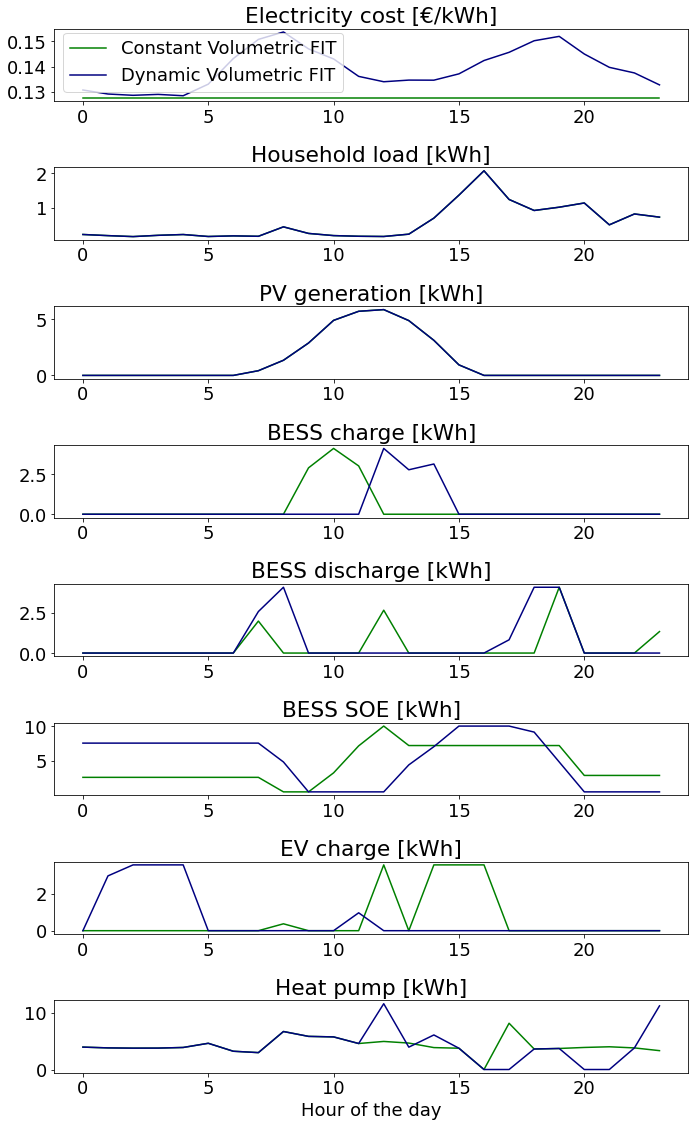

In [501]:

# Plotting
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 2 * len(cols)))

for idx, col in enumerate(cols):
    axes[idx].plot(temp_results1[col].values, color='green', label=first_case)
    axes[idx].plot(temp_results2[col].values, color='navy', label=second_case)
    axes[idx].set_title(col_namings[idx])
    if idx==0:
        axes[idx].legend()

plt.xlabel("Hour of the day")
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Grid draw [kWh]'}>

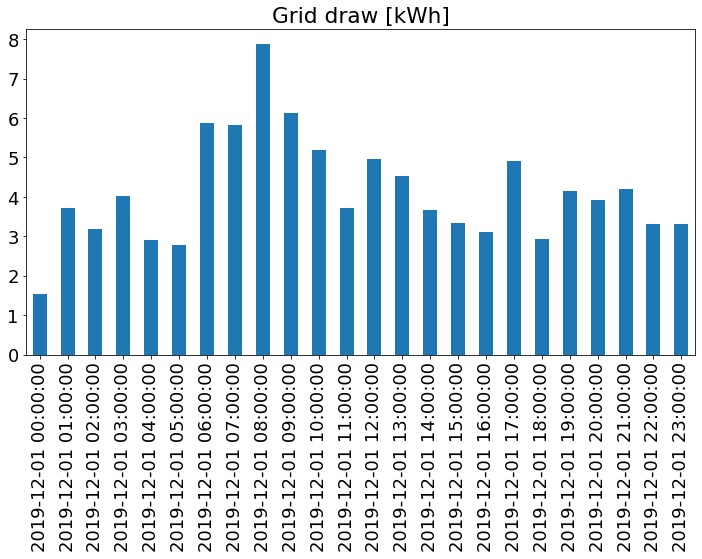

In [443]:
temp_results2["opt_net_energy"].plot.bar(title=("Grid draw [kWh]"))